# Technical demand response potential clustering

**Puporse and background**: This notebook serves for clustering the technical demand response potentials 
which were collected in a previous meta-analysis (Kochems 2020). This clustering routine is necessary since depicting all 
different units in the electricity market model would be computationally too expensive.

## Method applied
In the following, a brief description of the method applied is given for the sake of replicability.

### Filtering of demand response categories
The term "demand response categories" is introduced to describe the heterogeneous potential segmentation 
routines used in the publications evaluated within the meta-analysis. These demand response categories include 
processes, applications as well as entrire branches and mixtures of these categories.
* In the first step, data for entire branches is filtered out since in most cases there are too few data points and 
further information on availability is lacking. Thus, only data for processes and applications remains.
* In addition to that, categories covering different branches / appliances are filtered out since these would 
cause redundancies to publications analyzing the appliances in detail.

### Prepare and manipulate data for further usage (clustering / modeling)
In the second step, the data is manipulated for further usage in the clustering process as well as for the ensuing power market model analysis. This in turn consists of a few procedures:
* The data is combined to an overall data set and missing values are interpolated using the median value per sector. The parameters are filtered in order only to include those which are needed in demand response modeling in a power market model.
* A pairwhise correlation analysis using pearson's correlation coefficient is carried out in order to identify which parameters can be expressed through other ones since they show a high correlation. 
* Data is interpolated in order to remove inplausibilities. The data for the status quo is kept. The values for 2030 and 2050 are used to define trends in potential development. A linear interpolation is made in between. As far as the cost values are concerned, the values for the status quo as well as the minimum value are kept. The minimum value is assigned to 2050 and a linear interpolation is made in between.
> _Note: While the interpolation solution is preferable in terms of simplicity, it lacks some consistency: on the one hand in terms of a development of positive and negative potentials in line, on the other hand as for general trends within the sectors (such as declining industry production in the long run). This should be replaced by a more profound approach._

### Clustering of demand response categories
A clustering of demand response categories is carried out in the second step. 
A k-means clustering approach is used (as an alternative, it is possible to choose agglomerative clustering using ward linkage).<br>
Demand response categories are clustered using the (median values of the) following parameters (see also Steurer 2017, p. 83):
* shifting duration
* positive interference duration (shedding duration),
* variable costs,
* fixed costs and
* specific investments.

Some further aspects are worth mentioning:
* Negative interference duration is not taken into account because some processes are only eligible for load shedding and hence don't have a negative interference duration. In addition to that, a strong correlation between positive and negative interference duration has been detected.
* The clustering does not need to take into account the lower, middle and upper value for each parameter. A strong correlation between the values was determined which is why only the median values are used for the clustering. 
* Furthermore, the clustering is only carried out for the status quo and does not take development projections into account.
* The distinction between different sectors is kept. Some heating and cooling applications for tcs and households are combined since they comprise basically the same technology and creating identical clusters would not make much sense.
* For the aggregation of demand response parameters after clustering, a weighting by the available shifting resp. shedding capacity is carried out.

### Determination of availability
Since demand response potentials are time-dependent, availability has to be taken into account.<br>
For the analysis, the individual availability time series in hourly resolution of the original 
demand response categories are put together by calculating capacity weighted averages for the identified 
demand response clusters.

The availability time series are put together based on literature assumptions:
* The largest amount of the availability time series for individual demand response categories were created within three bachelor theses based on literature assumptions. They were put together in a separate notebook. The data output of this notebook in turn is read in here to form availability time series of demand response clusters.
* Some processes haven't been analyzed in the bachelor theses resp. the literature. For these, either existing availability time series of very similar demand response categories are assigned or own assumptions are made.
> _Note: These own assumptions for now are ("best guess") dummy values and should be replaced by more profound ones._
***

__*Important remaining TODOs:*__
* __*Revise parameters and potential development by including trend extrapolation / assumptions*__
* __*Revise proxies for availability time series*__
* __*Include the distinction between shifting and shedding &rarr; should be a criterion for separate cluster assignment*__

# Package imports
* Standard imports: scikit-learn (sklearn) is used for the clustering since it has built-in clustering routines, such as K-means
* User-defined functions:
    * *create_parameter_combinations*: Combines parameter names with measures of central tendency
    * *group_potential*: Does a grouping of the clusters determined using given aggregation functions per parameter
    * *wtrie_multiple_sheets*: Used to write multiple DataFrames as sheets at once into an Excel workbook
    * *map_column_names*: Maps column names of availability time series to the potential data column names.
    * *determine_missing_columns*: Lists the columns for which availability time series information is lacking and assumptions are needed.
    * *get_top_abs_correlations*: Determines the strongest correlation within a given correlation matrix.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.stats import linregress
from IPython.core.display import display

from potential_clustering_funcs import (
    create_parameter_combinations, group_potential, write_multiple_sheets,
    map_column_names, determine_missing_cols, assign_availability_remaining, get_top_abs_correlations
)

In [2]:
%matplotlib inline

# Parameter settings
Set path folder and filenames for reading in data.

Further parameters for controlling the workflow:
* *skip_dev*: If True, skip cells that are currently under development to keep overall functionality of notebook
* *write_outputs*: If True, outputs, i.e. demand response parameterizations resulting from the meta-analysis will be written into Excel workbooks
* *join_duplicates*: If True, demand response categories occuring in both, household and tcs sector will be combined together.
* *write_categories*: If True, the remaining categories will be written to Excel in order to match them with the
availability data.
* *adjust_potentials*: If True, availability time series information will be used to adjust the potential information. (I. e. if at max. 0.8 is reached, max potential will be set to 0.8 * max_potential)

Parameters for controlling the clustering routines:
* *cols*: Determine, which columns of the stats DataFrame shall be used for demand response parameterization
    * Usually lower and upper quartile as well as median are used.
> Note: This eliminates extreme values which are taken into account when min and max are used instead.<br>
The upper quartile of overall potential will be interpreted as maximum available potential. A possible alternative would be to use min and max values to depict extremes. &rarr; Advantage: would be more compelling. Drawback: Data lack for potential max.
* *cluster_parameters*: Determine, which demand response parameters to use for the clustering process. 
By default, these are the shifting duration, positive interference duration, variable costs as well as fixed costs.
* *cluster_algo*: The clustering algorithmn to be used ("KMeans" or "ward")
* *share_clusters*: Decide, how strong the original data will be reduced by giving a percentage of the original length. 
The cluster number is determined by the next higher integer. (Only applicable for k-means)
* *distance_threshold*: Decide, what distance threshold shall be set for the hierarchical clustering using ward 
linkage, i.e., when the algorithm should terminate.
* *print_clusters*: If True, prints out the clusters created (DataFrames)
* *use_ava_ts_for_profiles*: If True, availability time series in positive direction will be directly used to derive load profiles for the demand response categories resp. clusters, else profiles from the demand regio disaggregator will be applied

In [3]:
# Set path folder(s) and filename(s) for reading in / writing data
path_folder_in = "./"
path_folder_stats = "./out/stats/"
path_folder_availability = "./out/availability/"
path_folder_parameterization = "./out/parameterization/"
filename_in = "Potenziale_Lastmanagement.xlsx"
filename_availability_in = "availability_timeseries.xlsx"
filename_out = "parameterization"
filename_corr_out = "correlation"
filename_availability_out = "availability_timeseries_clusters.csv"
filename_load_profiles_out = "load_profile_timeseries_clusters"

# Set further parameters for controlling the workflow
skip_dev = True
write_outputs = True
join_duplicates = True
write_categories = True
adjust_potentials = True

# Determine clustering approach
quantile_cols = ["5%", "50%", "95%"]
cluster_parameters = [
    "shifting_duration", "interference_duration_pos", 
    "variable_costs", "fixed_costs", "specific_investments"
]

# Correlation analysis: optionally add potential_pos_overall (for all potential metrics)

cluster_algo = "KMeans"
share_clusters = 0.1
distance_threshold = 1000
print_clusters = True
use_ava_ts_for_profiles = True

# Read in and filter data
* Read in the categories data and filter out branches as well as power-to-X-technologies which won't be considered anymore.
* Read in the stats information on the demand response parameters from the previous meta-analysis.

> _NOTE: Data that is read in here could also be obtained directly from the DataFrames of the potential evaluation notebook. A separate notebook is used here only for the sake of shortness and readability._

## Read in and filter demand response categories
* Read in demand response categories
* Drop entire branches as well as categories conflicting with others or outside of scope (Power-to-X other than Power-to-Heat for space heating).
* Show the original number of categories and print the remaining number after filtering (without duplicates since categories may be used within different sectors).

In [4]:
categories = pd.read_excel(path_folder_in+filename_in, sheet_name="Kategorien_neu", index_col=0)

print("Number of original categories:\t{}".format(categories.shape[0]))

categories = categories[
    categories["Nutzung?"] == 1 
    & ~categories["Einstufung"].isin(["Branche", "Power-to-X"])
]

categories = categories.drop_duplicates(subset="Prozesskategorie")
categories = categories.set_index(["Prozesskategorie"], drop=True)

print("Number of remaining categories:\t{}".format(categories.shape[0]))

# Show the remaining demand response categories which are evaluated
list(categories.index.values)

Number of original categories:	99
Number of remaining categories:	38


['Chlor-Alkali-Elektrolyse',
 'Luftzerlegung',
 'Primäraluminiumelektrolyse',
 'Kupfer- und Zinkherstellung (Elektrolyse)',
 'Holz- und Zellstoffherstellung',
 'Altpapierrecycling (Pulper)',
 'Papiermaschinen',
 'Papierveredelung (Streichmaschinen und Kalander)',
 'Elektrostahlherstellung (Lichtbogenofen)',
 'Zementherstellung',
 'Kühlung (Lebensmittelindustrie)',
 'Belüftung',
 'Kühlhäuser',
 'Prozesskälte',
 'Klimakälte',
 'Warmwasserbereitstellung',
 'Nachtspeicherheizungen',
 'Notstromaggregate, Back-Up-Server und Mobilfunkstationen',
 'Waschmaschinen',
 'Wäschetrockner',
 'Geschirrspüler',
 'Kühlschränke',
 'Gefrierschränke und -truhen',
 'Wärmepumpen',
 'Heizungsumwälzpumpen',
 'Prozesswärme',
 'Druckluftanwendungen',
 'Abwasserbehandlung',
 'Kühl- und Gefrierkombinationen',
 'Calciumcarbid-Herstellung (Lichtbogenofen)',
 'Pumpenanwendungen in der Wasserversorgung',
 'Prozesskälte Handel',
 'Beleuchtung',
 'Pumpenanwendungen',
 'Gießereien (Induktionsofen)',
 'Zerkleinerer',
 'El

## Read in demand response parameters data
* Assign each demand response parameter an aggregation function to be used after clustering (sum or mean).
* Determine for which parameters to swap the order of preference.
> _Note: This is necessary, because in some cases minimum values are needed for an optimistic 
demand response projection and maximum for a pessimistic one, e.g. for minimum load factor. <br>
Hence, for these parameters, min is exchanged for max etc._
* Read in the data and store it in a dictionary indexed by demand response parameter. Hereby, a separation is necessary:
    * For the clustering process, certain appliances for the household and tcs sector should be combined, e.g. heat pumps. A new sector "tcs+hoho" is introduced for this purpose and the respective values are combined.
    * For calculating availabilities, a (re-)separation is necessary. This is because availability time series of the appliances may (slightly) differ among the sectors. &rarr; Herefore, a second dict is introduced.

In [5]:
# Assgin each parameter the aggregation function to be used
parameters_agg_dict = {
    "activation_duration": "mean", 
    "ave_load": "mean", 
    "fixed_costs": "mean", 
    "installed_cap": "sum",
    "interference_duration_neg": "mean", 
    "interference_duration_pos": "mean",
    "interference_duration_pos_shed": "mean",
    "max_load": "mean", 
    "maximum_activations_year": "mean", 
    "maximum_activations_year_shed": "mean",
    "min_load": "mean", 
    "potential_neg_overall": "sum",
    "potential_pos_overall": "sum",
    "potential_pos_overall_shed": "sum",
    "regeneration_duration": "mean", 
    "shiftable_share": "mean", 
    "shifting_duration": "mean",
    "specific_investments": "mean", 
    "variable_costs": "mean",
    "variable_costs_shed": "mean"
}

# Determine for each parameter whether or not to swap values
parameters_swap_dict = {
    "activation_duration": True, 
    "ave_load": True, 
    "fixed_costs": True, 
    "installed_cap": False,
    "interference_duration_neg": False, 
    "interference_duration_pos": False,
    "interference_duration_pos_shed": False,
    "max_load": False, 
    "maximum_activations_year": False, 
    "maximum_activations_year_shed": False,
    "min_load": True, 
    "potential_neg_overall": False,
    "potential_pos_overall": False,
    "potential_pos_overall_shed": False,
    "regeneration_duration": True, 
    "shiftable_share": False, 
    "shifting_duration": False,
    "specific_investments": True, 
    "variable_costs": True,
    "variable_costs_shed": True  
}

# Map columns for swapping
swap_cols = {
    "min": "max",
    "5%": "95%",
    "10%": "90%",
    "25%": "75%"
}

sectors = ["ind", "tcs", "hoho"]

years = ["SQ", "2020", "2025", "2030", "2035", "2040", "2045", "2050"]

to_join = ["Nachtspeicherheizungen", "Warmwasserbereitstellung", "Wärmepumpen", "Klimakälte"]
to_drop = {"Prozesskälte": "hoho"}

> _NOTE: While the fundamental routine here is quite okay and fast enough, there is room for improvement in the aggregation routine for the duplicates DataFrame, i.e. the DataFrame containing data for tcs+hoho which is then aggregated. Fo a compelling approach, a capacity weighted average should be calaculated using overall positive potential as capacity information. In order to do so, capacity information has to be added to the individual data sets._

In [6]:
categories.index

Index(['Chlor-Alkali-Elektrolyse', 'Luftzerlegung',
       'Primäraluminiumelektrolyse',
       'Kupfer- und Zinkherstellung (Elektrolyse)',
       'Holz- und Zellstoffherstellung', 'Altpapierrecycling (Pulper)',
       'Papiermaschinen', 'Papierveredelung (Streichmaschinen und Kalander)',
       'Elektrostahlherstellung (Lichtbogenofen)', 'Zementherstellung',
       'Kühlung (Lebensmittelindustrie)', 'Belüftung', 'Kühlhäuser',
       'Prozesskälte', 'Klimakälte', 'Warmwasserbereitstellung',
       'Nachtspeicherheizungen',
       'Notstromaggregate, Back-Up-Server und Mobilfunkstationen',
       'Waschmaschinen', 'Wäschetrockner', 'Geschirrspüler', 'Kühlschränke',
       'Gefrierschränke und -truhen', 'Wärmepumpen', 'Heizungsumwälzpumpen',
       'Prozesswärme', 'Druckluftanwendungen', 'Abwasserbehandlung',
       'Kühl- und Gefrierkombinationen',
       'Calciumcarbid-Herstellung (Lichtbogenofen)',
       'Pumpenanwendungen in der Wasserversorgung', 'Prozesskälte Handel',
       'Bel

Create a common data basis

In [7]:
# Put everything into one common pandas.DataFrame
all_params_df = pd.DataFrame()

# Count the number of params for which no data is available
count_ignored = 0

for parameter, swap_param in parameters_swap_dict.items():
    for year in years:
        for sector in sectors:
            try:
                new_df = pd.read_csv(
                    path_folder_stats+parameter+"_"+sector+"_stats_" + year + ".csv",
                    sep=";",
                    index_col=0
                ).T
                new_df.index.name = "Prozesskategorie"

                # Change the order of appearance if swap is needed for parameter
                if swap_param:
                    for k, v in swap_cols.items():
                        new_df[k + "_copy"] = new_df[k]
                        new_df[v + "_copy"] = new_df[v]
                        new_df[k] = new_df[v + "_copy"]
                        new_df[v] = new_df[k + "_copy"]
                        new_df.drop(columns=[k + "_copy", v + "_copy"], inplace=True)
                    
                new_df["parameter"] = parameter
                new_df["sector"] = sector
                new_df["year"] = year
                all_params_df = pd.concat([all_params_df, new_df], sort="False")
            except:
                count_ignored += 1
                continue

print(f"Overall number of params (sectors, years, params): "
      f"{len(parameters_agg_dict) * (len(sectors)) * len(years)}")
print(f"Number of params not eligible for evaluation: {count_ignored}")

Overall number of params (sectors, years, params): 480
Number of params not eligible for evaluation: 114


Drop values

In [8]:
# Filter out the categories to be used and drop certain ones for dedicated sector only
all_params_df = all_params_df.loc[all_params_df.index.isin(categories.index)]
all_params_df.set_index("sector", append=True, inplace=True)
all_params_df.drop(index={(k, v) for k, v in to_drop.items()}, inplace=True)
all_params_df.reset_index(level=1, inplace=True)

Combine duplicates for tcs & hoho

In [9]:
# Extend index and filter for duplicate values
all_params_df.set_index(["year", "parameter"], append=True, inplace=True)
filter_duplicates = (
    all_params_df.index.duplicated(keep=False)
    & all_params_df.sector.isin(["hoho", "tcs"])
)

# Get duplicates within duplicates (i.e. filter out the values where 
# the same demand response categories occur in tcs and industry sector)
duplicates_df = all_params_df.loc[filter_duplicates]
duplicates_df = duplicates_df[duplicates_df.index.duplicated(keep=False)]

# Filter out the remaining duplicate values from original DataFrame
keys = list(duplicates_df.columns.values)
i1 = all_params_df.set_index(keys).index
i2 = duplicates_df.set_index(keys).index
no_duplicates_df = all_params_df.loc[~i1.isin(i2)]

# Assign certain demand response categories to a combined tcs & hoho sector ("tcs+hoho")
for el in to_join:
    if el in no_duplicates_df.index:
        no_duplicates_df.loc[:,"help_sector"] = np.where(
            no_duplicates_df.loc[:,"sector"].values == "ind", "ind", "tcs+hoho"
        )
        no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
        no_duplicates_df = no_duplicates_df.drop(["help_sector"], axis=1)

C:\Users\koch_j0\.conda\envs\diss3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\koch_j0\.conda\envs\diss3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-9-96b63ffcc128>:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].va

In [10]:
# Drop index for grouping
duplicates_df.reset_index(drop=False, inplace=True)

# Introduce DataFrame for grouping duplicates (sector "tcs+hoho")
grouped_duplicates_df = pd.DataFrame()

for parameter, param_agg_rule in parameters_agg_dict.items():
    param_duplicates_df = duplicates_df.loc[duplicates_df["parameter"] == parameter]
    if not param_duplicates_df.empty:
        param_duplicates_df = param_duplicates_df.groupby(
            ["Prozesskategorie", "year", "parameter"]).agg({
                "count": "sum",
                "min": param_agg_rule,
                "5%": param_agg_rule,
                "10%": param_agg_rule,
                "25%": param_agg_rule,
                "50%": param_agg_rule,
                "mean": param_agg_rule,
                "std": param_agg_rule,
                "75%": param_agg_rule,
                "90%": param_agg_rule,
                "95%": param_agg_rule,
                "max": param_agg_rule,
            })
        grouped_duplicates_df = pd.concat([grouped_duplicates_df, param_duplicates_df])
        
grouped_duplicates_df["sector"] = "tcs+hoho"

# Combine the non-duplicated data with the consolidated tcs+hoho data
all_params_df = pd.concat([no_duplicates_df, grouped_duplicates_df], sort=False)

# Create unique index and round to four digits
all_params_df.set_index("sector", append=True, inplace=True)
all_params_df = all_params_df.round(4)

sectors.append("tcs+hoho")

In [11]:
all_params_df

10%  \
Prozesskategorie                           year parameter            sector               
Altpapierrecycling (Pulper)                SQ   activation_duration  ind         1.8858   
Calciumcarbid-Herstellung (Lichtbogenofen) SQ   activation_duration  ind         0.2500   
Chlor-Alkali-Elektrolyse                   SQ   activation_duration  ind         0.6250   
Elektrostahlherstellung (Lichtbogenofen)   SQ   activation_duration  ind         1.6000   
Gießereien (Induktionsofen)                SQ   activation_duration  ind         0.2500   
...                                                                                 ...   
Warmwasserbereitstellung                   2030 shifting_duration    tcs+hoho    4.9100   
                                           2050 shifting_duration    tcs+hoho    4.4400   
                                           SQ   shifting_duration    tcs+hoho    2.0875   
Klimakälte                                 2020 specific_investments tcs+hoho  132.3576   
                                           SQ   specific_investments tcs+hoho  606.7025   

                                                                                    25%  \
Prozesskategorie                           year parameter            sector               
Altpapierrecycling (Pulper)                SQ   activation_duration  ind         0.7038   
Calciumcarbid-Herstellung (Lichtbogenofen) SQ   activation_duration  ind         0.2292   
Chlor-Alkali-Elektrolyse                   SQ   activation_duration  ind         0.2500   
Elektrostahlherstellung (Lichtbogenofen)   SQ   activation_duration  ind         0.8220   
Gießereien (Induktionsofen)                SQ   activation_duration  ind         0.2292   
...                                                                                 ...   
Warmwasserbereitstellung                   2030 shifting_duration    tcs+hoho    7.0000   
                                           2050 shifting_duration    tcs+hoho    6.7500   
                                           SQ   shifting_duration    tcs+hoho    5.0000   
Klimakälte                                 2020 specific_investments tcs+hoho  105.3630   
                                           SQ   specific_investments tcs+hoho  422.1312   

                                                                                     5%  \
Prozesskategorie                           year parameter            sector               
Altpapierrecycling (Pulper)                SQ   activation_duration  ind         2.4429   
Calciumcarbid-Herstellung (Lichtbogenofen) SQ   activation_duration  ind         0.2500   
Chlor-Alkali-Elektrolyse                   SQ   activation_duration  ind         1.0000   
Elektrostahlherstellung (Lichtbogenofen)   SQ   activation_duration  ind         2.2667   
Gießereien (Induktionsofen)                SQ   activation_duration  ind         0.2500   
...                                                                                 ...   
Warmwasserbereitstellung                   2030 shifting_duration    tcs+hoho    4.3200   
                                           2050 shifting_duration    tcs+hoho    3.6000   
                                           SQ   shifting_duration    tcs+hoho    0.9812   
Klimakälte                                 2020 specific_investments tcs+hoho  141.3559   
                                           SQ   specific_investments tcs+hoho  668.2262   

                                                                                   50%  \
Prozesskategorie                           year parameter            sector              
Altpapierrecycling (Pulper)                SQ   activation_duration  ind        0.3746   
Calciumcarbid-Herstellung (Lichtbogenofen) SQ   activation_duration  ind        0.1667   
Chlor-Alkali-Elektrolyse                   SQ   activation_duration  ind        0.2221   
Elektrostahlherstellung (Lichtbogenofen)   SQ   activation_duration  ind        0.

# Prepare and manipulate data for further usage

## Reshape, fill nan values and re-combine data for cluster analysis
* Reshape data such that parameters are columns and process categories form the index.
* Fillna values based on defined rules:
    * If positive or negative potential is set while the other is not, define negative potential to equal positive one (or vice versa; assumption of symmetrical potentials).
    * Assign median values per sector and year for parameters dependent on an attribution to positive, negative or shedding potential
    * Assign 0 values to all remaining missing values.
    * Fill stll remaining Nan values with zero entries.

In [12]:
# All parameter columns
all_param_cols = [
    (a, b) for a in quantile_cols for b in parameters_agg_dict.keys()
]

# Define potential columns
potential_neg_cols = [
    (a, b) for a in quantile_cols for b in ["potential_neg_overall"]
]
potential_pos_cols = [
    (a, b) for a in quantile_cols for b in ["potential_pos_overall"]
]
potential_pos_shed_cols = [
    (a, b) for a in quantile_cols for b in ["potential_pos_overall_shed"]
]

# Fill nan for parameters when any of potential columns is not None
cols_any = [
    "activation_duration",
    "ave_load",
    "fixed_costs",
    "installed_cap",
    "max_load",
    "min_load",
    "regeneration_duration",
    "specific_investments"
]
cols_any = [(a, b) for a in quantile_cols for b in cols_any]

# Fill nan for parameters when shifting is possible
cols_shift = [
    "maximum_activations_year",
    "shiftable_share",
    "shifting_duration",
    "variable_costs"
]
cols_shift = [(a, b) for a in quantile_cols for b in cols_shift]

# Fill nan for parameters when negative / positive / shedding potential information is given
cols_neg = [
    "interference_duration_neg",
]
cols_neg = [(a, b) for a in quantile_cols for b in cols_neg]

cols_pos = [
    "interference_duration_pos"
]
cols_pos = [(a, b) for a in quantile_cols for b in cols_pos]

cols_shed = [
    "interference_duration_pos_shed",
    "maximum_activations_year_shed",
    "variable_costs_shed"
]
cols_shed = [(a, b) for a in quantile_cols for b in cols_shed]

In [13]:
# Reshape data for correlation analysis
all_params_reshaped = pd.DataFrame()

for year in years:

    # Due to multiple indices (duplicate categories for ind / tcs) needs to be done by sector
    for sector in sectors:
        reshaped_df = all_params_df.loc[
            (all_params_df.index.get_level_values(1) == year)
            & (all_params_df.index.get_level_values(3) == sector)
        ]

        # Restructure the data: process categories row-wise, parameters column-wise
        reshaped_df.drop(
            columns=[
                col for col in reshaped_df.columns 
                if col not in quantile_cols
            ], 
            inplace=True
        )

        reshaped_df.reset_index(drop=False, inplace=True)
        reshaped_df = reshaped_df.pivot(
            index=["Prozesskategorie", "sector", "year"], 
            columns=["parameter"]
        )
        reshaped_df = reshaped_df.reindex(columns=all_param_cols)
        
        # Determine processes, for which (no) potential information is given
        neg_nan_idx = reshaped_df[
            reshaped_df[[col for col in potential_neg_cols]].isna().all(axis=1)
        ].index

        neg_not_nan_idx = [
            idx for idx in reshaped_df.index if idx not in neg_nan_idx 
        ]

        pos_nan_idx = reshaped_df[
            reshaped_df[[col for col in potential_pos_cols]].isna().all(axis=1)
        ].index

        pos_not_nan_idx = [
            idx for idx in reshaped_df.index if idx not in pos_nan_idx
        ]

        pos_shed_nan_idx = reshaped_df[
            reshaped_df[[col for col in potential_pos_shed_cols]].isna().all(axis=1)
        ].index

        pos_shed_not_nan_idx = [
            idx for idx in reshaped_df.index if idx not in pos_shed_nan_idx
        ]

        neg_missing = neg_nan_idx.difference(pos_nan_idx)
        pos_missing = pos_nan_idx.difference(neg_nan_idx)

        # Fill categories missing negative potential with positive one as a proxy
        reshaped_df.loc[neg_missing, potential_neg_cols] = (
            reshaped_df.loc[neg_missing, potential_pos_cols].values
        )

        # Fill categories missing positive potential with negative one as a proxy
        reshaped_df.loc[pos_missing, potential_pos_cols] = (
            reshaped_df.loc[pos_missing, potential_neg_cols].values
        )

        # Fill non-potential parameters dependent on potentials given
        for col in cols_neg + cols_shift + cols_any:
            reshaped_df.loc[neg_not_nan_idx, col] = (
                reshaped_df.loc[neg_not_nan_idx, col].fillna(
                    reshaped_df[col].median() 
                )
            )

        for col in cols_pos + cols_shift + cols_any:
            reshaped_df.loc[pos_not_nan_idx, col] = (
                reshaped_df.loc[pos_not_nan_idx, col].fillna(
                    reshaped_df[col].median() 
                )
            )

        for col in cols_shed + cols_any:
            reshaped_df.loc[pos_shed_not_nan_idx, col] = (
                reshaped_df.loc[pos_shed_not_nan_idx, col].fillna(
                    reshaped_df[col].median() 
                )
            )
        
        # Combine
        all_params_reshaped = pd.concat([all_params_reshaped, reshaped_df])
    
    # Fill remaining nans
    all_params_reshaped = all_params_reshaped.fillna(0).round(2)
    all_params_reshaped.sort_index(axis=1, level=1, inplace=True)

C:\Users\koch_j0\.conda\envs\diss3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\koch_j0\.conda\envs\diss3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [14]:
all_params_reshaped

,,,5%,50%,95%,5%,50%,95%,5%,50%,95%,5%,...,95%,5%,50%,95%,5%,50%,95%,5%,50%,95%
,,parameter,activation_duration,activation_duration,activation_duration,ave_load,ave_load,ave_load,fixed_costs,fixed_costs,fixed_costs,installed_cap,...,shifting_duration,specific_investments,specific_investments,specific_investments,variable_costs,variable_costs,variable_costs,variable_costs_shed,variable_costs_shed,variable_costs_shed
Prozesskategorie,sector,year,,,,,,,,,,,,,,,,,,,,,
Altpapierrecycling (Pulper),ind,SQ,2.44,0.37,0.03,0.88,0.80,0.68,3.77,1.02,0.00,413.80,...,31.2,3.64,1.58,0.12,286.21,166.89,66.60,476.97,433.01,389.05
Beleuchtung,ind,SQ,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Belüftung,ind,SQ,1.00,0.22,0.03,0.60,0.29,0.19,3.80,1.02,0.00,255.20,...,25.5,390.96,10.38,6.80,390.70,178.09,66.60,0.00,0.00,0.00
Calciumcarbid-Herstellung (Lichtbogenofen),ind,SQ,0.25,0.17,0.08,0.86,0.80,0.73,29.00,15.26,1.53,58.20,...,31.2,12.47,5.60,0.46,666.92,377.04,172.80,1222.80,1136.71,1050.62
Chlor-Alkali-Elektrolyse,ind,SQ,1.00,0.22,0.00,0.93,0.87,0.83,1.27,0.08,0.00,895.70,...,10.4,6.78,0.51,0.00,185.72,106.57,9.87,721.37,244.24,60.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wäschetrockner,hoho,2050,0.00,0.00,0.00,0.02,0.01,0.00,759.46,749.29,113.15,17201.70,...,9.0,100.38,87.87,38.96,0.00,0.00,0.00,0.00,0.00,0.00
Klimakälte,tcs+hoho,2050,0.00,0.00,0.00,0.53,0.13,0.01,41.96,36.74,5.75,43949.88,...,1.7,28.01,24.58,5.19,4.67,0.00,0.00,0.00,0.00,0.00


## Do a correlation analysis of parameters in order to derive cluster parameters
General idea:
* Check pairwise correlations between parameters to detect autocorrelation and derive parameters used for clustering.
* If correlation between to parameters is above 0.8, choose one of both.

In [15]:
corr_matrix = all_params_reshaped.loc[
    all_params_reshaped.index.get_level_values(2) == "SQ"
].corr().round(2).fillna(0)

# Transform to 1-dimensional indices
corr_matrix["new_index"] = (
    corr_matrix.index.get_level_values(0) + "_" + corr_matrix.index.get_level_values(1)
)
corr_matrix.set_index("new_index", drop=True, inplace=True)
corr_matrix.columns = (
    corr_matrix.columns.get_level_values(0) + "_" + corr_matrix.columns.get_level_values(1)
)

In [16]:
# Display the top 10 largest correlations
print("Top Absolute Correlations")
print(75 * "-")
display(get_top_abs_correlations(corr_matrix, n=10))

Top Absolute Correlations
---------------------------------------------------------------------------


50%_regeneration_duration       95%_regeneration_duration         1.000000
5%_regeneration_duration        50%_regeneration_duration         1.000000
                                95%_regeneration_duration         1.000000
50%_max_load                    95%_max_load                      0.999720
5%_max_load                     50%_max_load                      0.999627
                                95%_max_load                      0.998908
5%_installed_cap                95%_installed_cap                 0.998678
50%_potential_pos_overall_shed  95%_potential_pos_overall_shed    0.998507
50%_installed_cap               95%_installed_cap                 0.996812
5%_installed_cap                50%_installed_cap                 0.995953
dtype: float64

In [17]:
# Determine and store top correlations
top_corr_series = get_top_abs_correlations(corr_matrix, threshold=0.8)
top_corr_series.name = "pearson_correlation"
corr_dict = {}

# Filter for params and quantiles
ix1_slice_end = top_corr_series.index.get_level_values(0).str.split(
    "_", 1, expand=True
).get_level_values(1)
ix2_slice_end = top_corr_series.index.get_level_values(1).str.split(
    "_", 1, expand=True
).get_level_values(1)
ix1_slice_start = top_corr_series.index.get_level_values(0).str.split(
    "_", 1, expand=True
).get_level_values(0)
ix2_slice_start = top_corr_series.index.get_level_values(1).str.split(
    "_", 1, expand=True
).get_level_values(0)

corr_dict["same_params"] = top_corr_series[ix1_slice_end == ix2_slice_end]
corr_dict["different_params"] = top_corr_series[ix1_slice_end != ix2_slice_end]
corr_dict["only_medians"] = top_corr_series[
    (ix1_slice_end != ix2_slice_end)
    & (ix1_slice_start == "50%") 
    & (ix2_slice_start == "50%")
]

if write_outputs:
    write_multiple_sheets(
        corr_dict, path_folder_parameterization, filename_corr_out + ".xlsx"
    )

In [18]:
# Evaluate correlations for medians only
ix_slice_start = corr_matrix.index.str.split(
    "_", 1, expand=True
).get_level_values(0)

corr_matrix_50 = corr_matrix.loc[
    ix_slice_start == "50%", 
    [col for col in corr_matrix if "50%" in col]
]

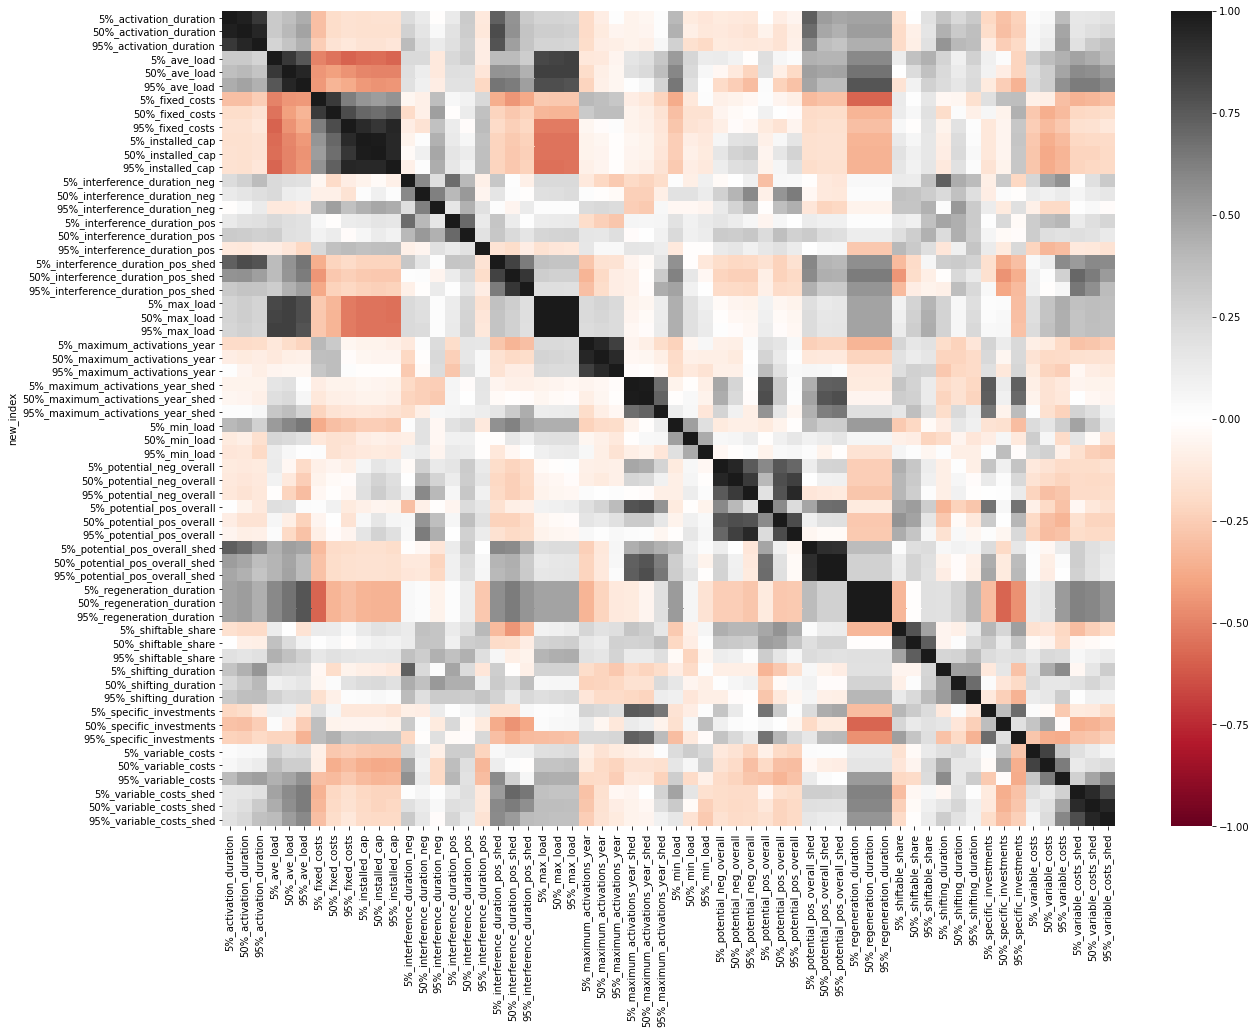

In [19]:
# Show heatmap for all correlations
fig, ax = plt.subplots(figsize=(20, 15))
_ = sns.heatmap(corr_matrix, cmap="RdGy", vmin=-1.0, vmax=1.0)
plt.show()

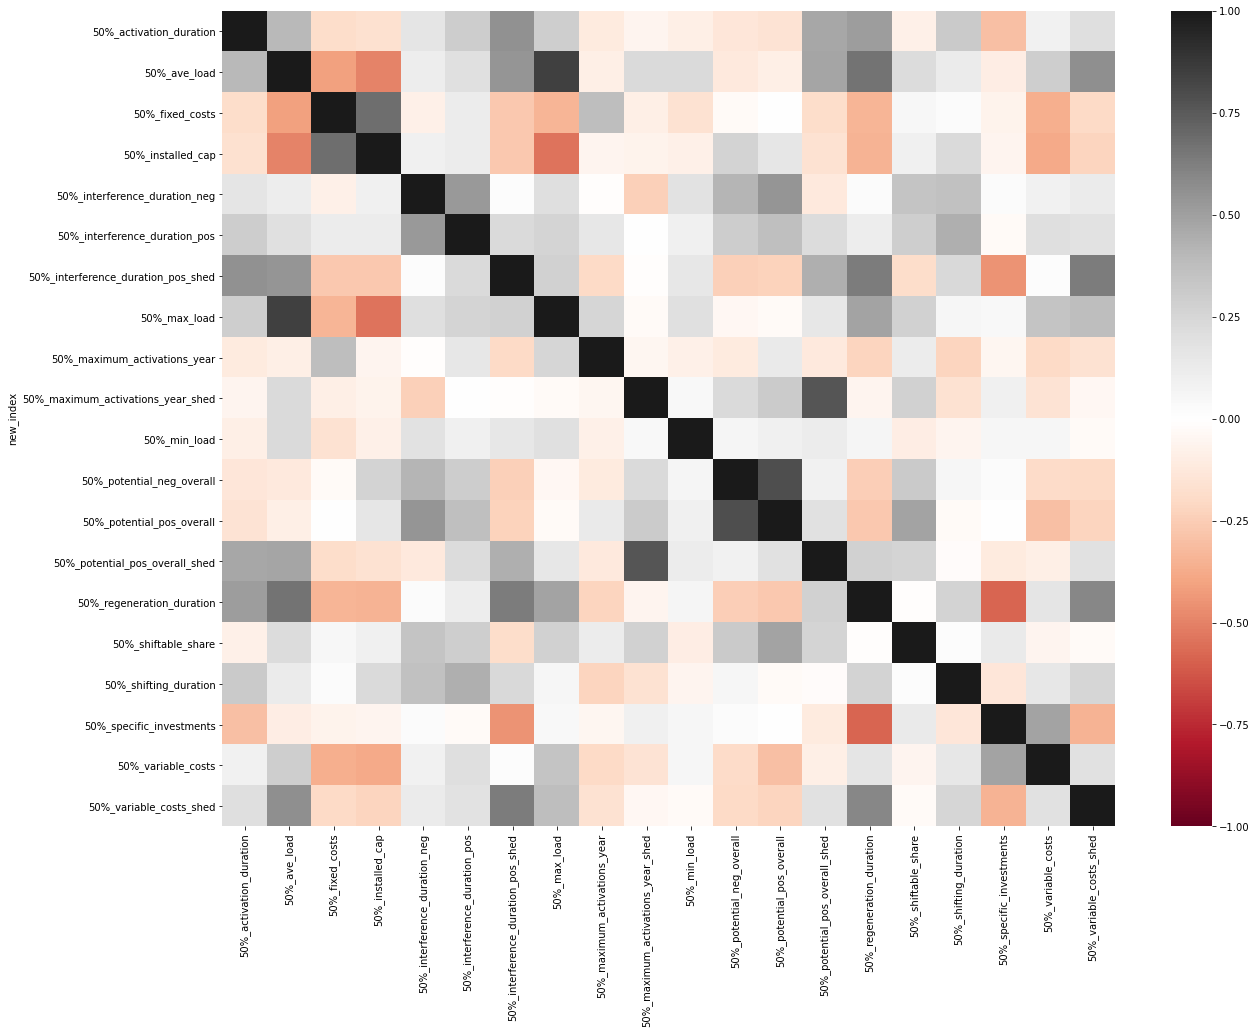

In [20]:
# Show heatmap for median values only
fig, ax = plt.subplots(figsize=(20, 15))
_ = sns.heatmap(corr_matrix_50, cmap="RdGy", vmin=-1.0, vmax=1.0)
plt.show()

## Create consistent trends for future developments
Overview on approach used:
1. Introduce **linear interpolation** for potential and cost parameters:
    * Potential parameters: The values for the status quo, 2030 and 2050 are used. Linear interpolation is made in between.
    * Cost parameters: The minimum cost value is assigned to 2050 since cost increases seem pretty unlikely. Linear interpolation is made between the status quo and 2050 (minimum cost value). Costs of zero are set to 0.01 in order to attribute cost to DR and prevent numeric effects disturbing DR utilization in the model.
2. **Assign remaining** parameters (mostly time-related ones) the same as for the status quo for every year.

Only a **subset of the parameters** needs to be further analyzed since not every parameter is needed for modelling:
* Time-dependent parameters are assumed constant. These comprise:
    * activation duration
    * interference duration (both pos and neg) and shifting duration
    * regeneration duration
* Other parameters are not really resp. not directly used in the modeling approaches for DR. These comprise:
    * average, minimum and maximum load
* This leads to the following remaining parameters focussing on costs and potentials. Since the correlation analysis showed high redundandencies for the potential parameters, only the following remaining parameters will be further analyzed:
    * potential positive overall
    * potential negative overall
    * installed capacity
    * fixed and variable costs
    * specific investments

### Linear interpolation for potential and costs data
* Choose potential and cost parameters to further analyse
* Perform **interpolation on potential and costs parameters** in order to
    1. Fill data gaps and
    2. remove inplausibilities such as potentials changing very strong and not consistent within the five year intervalls used.
* Combine the data to an overall data set once the actions described in the following are done.

In order to come up with consistent trends, it is proceeded as follows:
* For *potential-related* parameters, values for the status quo, 2030 and 2050 are assessed. This serves to
    * depict intermediate trends (such as a temporary increase of a technology) and
    * create a consistent long-term development.
* For *potential-related* parameters, a strong interlinkage exists. In order not to create inconsistencies, development factors are assessed for each of the potential-related columns and the median one is used. This serves to prevent inconsistensies, such as a strongly increasing positive shifting potential while installed capacity only weakly increases or even decreases.
* For *cost-related* parameters, the minimum cost value given is assigned to 2050, thus assuming a cost reduction over time. Zero cost values are replaced by small costs (0.01) in order to prevent modelling artefacts.

In [21]:
# choose parameters to be used (parameters for which some adaptions are needed)
params_to_use = [
    "potential_neg_overall",
    "potential_pos_overall",
    "potential_pos_overall_shed",
    "installed_cap",
    "fixed_costs",
    "variable_costs",
    "variable_costs_shed",
    "specific_investments"
]

params_to_use = [(a, b) for a in quantile_cols for b in params_to_use]

# Slice the parameter values needed
slice_params = all_params_reshaped.loc[:, params_to_use]

In [22]:
slice_params

5%  \
parameter                                                potential_neg_overall   
Prozesskategorie                           sector   year                         
Altpapierrecycling (Pulper)                ind      SQ                   33.50   
Beleuchtung                                ind      SQ                    0.00   
Belüftung                                  ind      SQ                    0.00   
Calciumcarbid-Herstellung (Lichtbogenofen) ind      SQ                    4.35   
Chlor-Alkali-Elektrolyse                   ind      SQ                   35.60   
...                                                                        ...   
Wäschetrockner                             hoho     2050                  0.00   
Klimakälte                                 tcs+hoho 2050                 15.77   
Nachtspeicherheizungen                     tcs+hoho 2050                920.60   
Warmwasserbereitstellung                   tcs+hoho 2050                  0.00   
Wärmepumpen                                tcs+hoho 2050                  0.00   

                                                                                \
parameter                                                potential_pos_overall   
Prozesskategorie                           sector   year                         
Altpapierrecycling (Pulper)                ind      SQ                  357.50   
Beleuchtung                                ind      SQ                    0.00   
Belüftung                                  ind      SQ                    0.97   
Calciumcarbid-Herstellung (Lichtbogenofen) ind      SQ                    4.35   
Chlor-Alkali-Elektrolyse                   ind      SQ                  267.15   
...                                                                        ...   
Wäschetrockner                             hoho     2050                  0.00   
Klimakälte                                 tcs+hoho 2050                925.86   
Nachtspeicherheizungen                     tcs+hoho 2050                157.50   
Warmwasserbereitstellung                   tcs+hoho 2050                 73.57   
Wärmepumpen                                tcs+hoho 2050                670.46   

                                                                                     \
parameter                                                potential_pos_overall_shed   
Prozesskategorie                           sector   year                              
Altpapierrecycling (Pulper)                ind      SQ                       410.70   
Beleuchtung                                ind      SQ                         0.00   
Belüftung                                  ind      SQ                         0.00   
Calciumcarbid-Herstellung (Lichtbogenofen) ind      SQ                        41.40   
Chlor-Alkali-Elektrolyse                   ind      SQ                       482.75   
...                                                                             ...   
Wäschetrockner                             hoho     2050                       0.00   
Klimakälte                                 tcs+hoho 2050                       0.00   
Nachtspeicherheizungen                     tcs+hoho 2050                       0.00   
Warmwasserbereitstellung                   tcs+hoho 2050                       0.00   
Wärmepumpen                                tcs+hoho 2050                       0.00   

                                                                        \
parameter                                                installed_cap   
Prozesskategorie                           sector   year                 
Altpapierrecycling (Pulper)                ind      SQ          413.80   
Beleuchtung                                ind      SQ            0.00   
Belüftung                                  ind      SQ          255.20   
Calciumcarbid-Herstellung (Lichtbogenofen) ind      SQ           58.20   
Chlor-Alkali-Elektrolyse                 

In [23]:
# Define potential and cost cols
pot_cols = [
    "potential_neg_overall",
    "potential_pos_overall", 
    "potential_pos_overall_shed",
    "installed_cap"
]
pot_cols = [(a, b) for a in quantile_cols for b in pot_cols]

cost_cols = [
    "specific_investments", 
    "fixed_costs", 
    "variable_costs",
    "variable_costs_shed"
]
cost_cols = [(a, b) for a in quantile_cols for b in cost_cols]

# Determine demand response categories to use for assigning values:
# Use first two index levels corresponding to process category and sector
dr_categories = all_params_reshaped.reset_index(level=2).index.unique()

In [24]:
# Instanciate new DataFrame to store manipulated outputs
parameters_for_clustering = pd.DataFrame(
    index=pd.MultiIndex.from_product([[],[],[]],
    names=["Prozesskategorie", "sector", "year"]),
    columns=pd.MultiIndex.from_product([[], []])
)

# Create a list of DataFrames to concat
to_concat = [parameters_for_clustering]

for category in dr_categories:
    process = category[0]
    sector = category[1]

    # Use potential values for status quo, 2030 and 2050
    try:
        pot_vals_SQ = slice_params.loc[(process, sector, "SQ"), pot_cols].values
    except KeyError:
        continue
    try:
        pot_vals_2030 = slice_params.loc[(process, sector, "2030"), pot_cols].values
    except:
        pot_vals_2030 = np.nan
    try:
        pot_vals_2050 = slice_params.loc[(process, sector, "2050"), pot_cols].values
    except:
        pot_vals_2050 = pot_vals_SQ
    
    # Determine median development factors to create consistent trends
    factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
    factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)
    
    multi_ix = pd.MultiIndex.from_product(
        [[process], [sector], years], 
        names=["Prozesskategorie", "sector", "year"]
    )
    new_df = pd.DataFrame(
        index=multi_ix, 
        columns=pd.MultiIndex.from_tuples(pot_cols + cost_cols)
    )
    
    new_df.loc[(process, sector, "SQ"), pot_cols] = pot_vals_SQ
    new_df.loc[(process, sector, "2030"), pot_cols] = pot_vals_2030 * factor_2030
    new_df.loc[(process, sector, "2050"), pot_cols] = pot_vals_2050 * factor_2050
    
    # Use cost values
    cost_vals_SQ = slice_params.loc[(process, sector, "SQ"), cost_cols]     
    min_costs = slice_params[cost_cols].min()

    # Assign minimum cost value to the year 2050
    new_df.loc[(process, sector, "SQ"), cost_cols] = cost_vals_SQ.fillna(0.01)
    new_df.loc[(process, sector, "2050"), cost_cols] = min_costs
    new_df[cost_cols] = new_df[cost_cols].replace({0: 0.01})
    
    # Correct dtype, interpolate between status quo, 2030 and 2050 and create common data basis again
    new_df = new_df.astype("float64")
    new_df = new_df.interpolate(axis=0)
    
    to_concat.append(new_df)

parameters_for_clustering = pd.concat([el for el in to_concat], levels=([0, 1, 2]))

5%  \
                                        potential_neg_overall   
Prozesskategorie            sector year                         
Altpapierrecycling (Pulper) ind    SQ               33.500000   
                                   2020             35.395837   
                                   2025             37.291674   
                                   2030             39.187511   
                                   2035             42.308369   
                                   2040             45.429227   
                                   2045             48.550085   
                                   2050             51.670943   

                                                               \
                                        potential_pos_overall   
Prozesskategorie            sector year                         
Altpapierrecycling (Pulper) ind    SQ              357.500000   
                                   2020            251.395837   
                                   2025            145.291674   
                                   2030             39.187511   
                                   2035             42.308369   
                                   2040             45.429227   
                                   2045             48.550085   
                                   2050             51.670943   

                                                                    \
                                        potential_pos_overall_shed   
Prozesskategorie            sector year                              
Altpapierrecycling (Pulper) ind    SQ                   410.700000   
                                   2020                 462.051960   
                                   2025                 513.403920   
                                   2030                 564.755879   
                                   2035                 609.697386   
                                   2040                 654.638893   
                                   2045                 699.580400   
                                   2050                 744.521907   

                                                                        50%  \
                                        installed_cap potential_neg_overall   
Prozesskategorie            sector year                                       
Altpapierrecycling (Pulper) ind    SQ      413.800000            123.000000   
                                   2020    509.040253            126.004168   
                                   2025    604.280506            129.008336   
                                   2030    699.520760            132.012505   
                                   2035    752.640544            142.517838   
                                   2040    805.760328            153.023171   
                                   2045    858.880113            163.528505   
                                   2050    911.999897            174.033838   

                                                               \
                                        potential_pos_overall   
Prozesskategorie            sector year                         
Altpapierrecycling (Pulper) ind    SQ              424.500000   
                                   2020            327.004168   
                                   2025            229.508336   
                                   2030            132.012505   
                                   2035            142.517838   
                                   2040            153.023171   
                                   2045            163.528505   
                                   2050            174.033838   

                                                                    \
                                        potential_pos_overall_shed   
Prozesskategorie            sector year                              
Altpapierrecycling (Pulper) ind    SQ                    588

C:\Users\koch_j0\.conda\envs\diss3\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Beleuchtung      ind    SQ                     0.0                   0.0   
                        2020                   0.0                   0.0   
                        2025                   0.0                   0.0   
                        2030                   0.0                   0.0   
                        2035                   0.0                   0.0   
                        2040                   0.0                   0.0   
                        2045                   0.0                   0.0   
                        2050                   0.0                   0.0   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Beleuchtung      ind    SQ                          0.0           0.0   
                        2020                        0.0           0.0   
                        2025                        0.0           0.0   
                        2030                        0.0           0.0   
                        2035                        0.0           0.0   
                        2040                        0.0           0.0   
                        2045                        0.0           0.0   
                        2050                        0.0           0.0   

                                               50%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Beleuchtung      ind    SQ                     0.0                   0.0   
                        2020                   0.0                   0.0   
                        2025                   0.0                   0.0   
                        2030                   0.0                   0.0   
                        2035                   0.0                   0.0   
                        2040                   0.0                   0.0   
                        2045                   0.0                   0.0   
                        2050                   0.0                   0.0   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Beleuchtung      ind    SQ                          0.0           0.0   
                        2020                        0.0           0.0   
                        2025                        0.0           0.0   
                        2030                        0.0           0.0   
                        2035                        0.0           0.0   
                        2040                        0.0           0.0   
                        2045                        0.0           0.0   
                        2050                        0.0           0.0   

                                               95%                        ...  \
                             potential_neg_overall potential_pos_overall  ...   
Prozesskategorie sector year                                              ...   
Beleuchtung      ind    SQ                     0.0                   0.0  ...   
                        2020                   0.0                   0.0  ...   
                        2025                   0.0                   0.0  ...   
                        2030                   0.0                   0.0  ...   
                        2035                   0.0                   0.0  ...   
                        2040                   0.0                   0.0  ...   
                        2045         

<ipython-input-24-09bbb551eb25>:30: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Belüftung        ind    SQ                     0.0              0.970000   
                        2020                   0.0              0.952571   
                        2025                   0.0              0.935142   
                        2030                   0.0              0.917713   
                        2035                   0.0              0.968596   
                        2040                   0.0              1.019480   
                        2045                   0.0              1.070364   
                        2050                   0.0              1.121247   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Belüftung        ind    SQ                          0.0    255.200000   
                        2020                        0.0    250.271326   
                        2025                        0.0    245.342653   
                        2030                        0.0    240.413979   
                        2035                        0.0    256.004597   
                        2040                        0.0    271.595215   
                        2045                        0.0    287.185833   
                        2050                        0.0    302.776452   

                                               50%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Belüftung        ind    SQ               14.300000             11.970000   
                        2020             13.308132             11.490474   
                        2025             12.316264             11.010947   
                        2030             11.324396             10.531421   
                        2035             11.953783             11.118430   
                        2040             12.583171             11.705440   
                        2045             13.212559             12.292450   
                        2050             13.841946             12.879460   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Belüftung        ind    SQ                          0.0    374.000000   
                        2020                        0.0    348.541335   
                        2025                        0.0    323.082671   
                        2030                        0.0    297.624006   
                        2035                        0.0    316.827267   
                        2040                        0.0    336.030529   
                        2045                        0.0    355.233790   
                        2050                        0.0    374.437051   

                                               95%                        ...  \
                             potential_neg_overall potential_pos_overall  ...   
Prozesskategorie sector year                                              ...   
Belüftung        ind    SQ              321.750000           1022.500000  ...   
                        2020            223.228665            692.756437  ...   
                        2025            124.707330            363.012873  ...   
                        2030             26.185994             33.269310  ...   
                        2035             27.644507             35.120108  ...   
                        2040             29.103019             36.970905  ...   
                        2045         

5%  \
                                                       potential_neg_overall   
Prozesskategorie                           sector year                         
Calciumcarbid-Herstellung (Lichtbogenofen) ind    SQ                4.350000   
                                                  2020              3.875786   
                                                  2025              3.401572   
                                                  2030              2.927358   
                                                  2035              2.639982   
                                                  2040              2.352607   
                                                  2045              2.065232   
                                                  2050              1.777856   

                                                                              \
                                                       potential_pos_overall   
Prozesskategorie                           sector year                         
Calciumcarbid-Herstellung (Lichtbogenofen) ind    SQ                4.350000   
                                                  2020              3.875786   
                                                  2025              3.401572   
                                                  2030              2.927358   
                                                  2035              2.639982   
                                                  2040              2.352607   
                                                  2045              2.065232   
                                                  2050              1.777856   

                                                                                   \
                                                       potential_pos_overall_shed   
Prozesskategorie                           sector year                              
Calciumcarbid-Herstellung (Lichtbogenofen) ind    SQ                    41.400000   
                                                  2020                  36.879533   
                                                  2025                  32.359066   
                                                  2030                  27.838599   
                                                  2035                  25.115746   
                                                  2040                  22.392894   
                                                  2045                  19.670042   
                                                  2050                  16.947190   

                                                                      \
                                                       installed_cap   
Prozesskategorie                           sector year                 
Calciumcarbid-Herstellung (Lichtbogenofen) ind    SQ       58.200000   
                                                  2020     51.843279   
                                                  2025     45.486557   
                                                  2030     39.129836   
                                                  2035     35.302875   
                                                  2040     31.475914   
                                                  2045     27.648954   
                                                  2050     23.821993   

                                                                         50%  \
                                                       potential_neg_overall   
Prozesskategorie                           sector year                         
Calciumcarbid-Herstellung (Lichtbogenofen) ind    SQ               13.000000   
                                                  2020             11.514759   
                                                  2025             10.029518   
                                                  2030              8.544277   
                       

5%  \
                                     potential_neg_overall   
Prozesskategorie         sector year                         
Chlor-Alkali-Elektrolyse ind    SQ               35.600000   
                                2020             49.206404   
                                2025             62.812809   
                                2030             76.419213   
                                2035             65.156030   
                                2040             53.892846   
                                2045             42.629663   
                                2050             31.366479   

                                                            \
                                     potential_pos_overall   
Prozesskategorie         sector year                         
Chlor-Alkali-Elektrolyse ind    SQ              267.150000   
                                2020            300.603086   
                                2025            334.056171   
                                2030            367.509257   
                                2035            283.473562   
                                2040            199.437868   
                                2045            115.402174   
                                2050             31.366479   

                                                                               \
                                     potential_pos_overall_shed installed_cap   
Prozesskategorie         sector year                                            
Chlor-Alkali-Elektrolyse ind    SQ                   482.750000    895.700000   
                                2020                 396.069420    907.685508   
                                2025                 309.388840    919.671016   
                                2030                 222.708260    931.656525   
                                2035                 194.291362    848.060291   
                                2040                 165.874464    764.464058   
                                2045                 137.457566    680.867825   
                                2050                 109.040668    597.271591   

                                                       50%  \
                                     potential_neg_overall   
Prozesskategorie         sector year                         
Chlor-Alkali-Elektrolyse ind    SQ              299.000000   
                                2020            271.089336   
                                2025            243.178672   
                                2030            215.268009   
                                2035            177.215362   
                                2040            139.162715   
                                2045            101.110068   
                                2050             63.057421   

                                                            \
                                     potential_pos_overall   
Prozesskategorie         sector year                         
Chlor-Alkali-Elektrolyse ind    SQ              622.000000   
                                2020            621.884193   
                                2025            621.768386   
                                2030            621.652579   
                                2035            482.003789   
                                2040            342.355000   
                                2045            202.706210   
                                2050             63.057421   

                                                                               \
                                     potential_pos_overall_shed installed_cap   
Prozesskategorie         sector year                                            
Chlor-Alkali-Elektrolyse ind    SQ                   575.000000   1408.000000   
                                2020                 528.392128   1405.878555   
                           

C:\Users\koch_j0\.conda\envs\diss3\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%                        \
                                 potential_neg_overall potential_pos_overall   
Prozesskategorie     sector year                                               
Druckluftanwendungen ind    SQ                   56.15                 33.56   
                            2020                 56.15                 33.56   
                            2025                 56.15                 33.56   
                            2030                 56.15                 33.56   
                            2035                 56.15                 33.56   
                            2040                 56.15                 33.56   
                            2045                 56.15                 33.56   
                            2050                 56.15                 33.56   

                                                                           \
                                 potential_pos_overall_shed installed_cap   
Prozesskategorie     sector year                                            
Druckluftanwendungen ind    SQ                          0.0         285.5   
                            2020                        0.0         285.5   
                            2025                        0.0         285.5   
                            2030                        0.0         285.5   
                            2035                        0.0         285.5   
                            2040                        0.0         285.5   
                            2045                        0.0         285.5   
                            2050                        0.0         285.5   

                                                   50%                        \
                                 potential_neg_overall potential_pos_overall   
Prozesskategorie     sector year                                               
Druckluftanwendungen ind    SQ                  1045.5                910.85   
                            2020                1045.5                910.85   
                            2025                1045.5                910.85   
                            2030                1045.5                910.85   
                            2035                1045.5                910.85   
                            2040                1045.5                910.85   
                            2045                1045.5                910.85   
                            2050                1045.5                910.85   

                                                                           \
                                 potential_pos_overall_shed installed_cap   
Prozesskategorie     sector year                                            
Druckluftanwendungen ind    SQ                          0.0        494.75   
                            2020                        0.0        494.75   
                            2025                        0.0        494.75   
                            2030                        0.0        494.75   
                            2035                        0.0        494.75   
                            2040                        0.0        494.75   
                            2045                        0.0        494.75   
                            2050                        0.0        494.75   

                                                   95%                        \
                                 potential_neg_overall potential_pos_overall   
Prozesskategorie     sector year                                               
Druckluftanwendungen ind    SQ                  2578.0                1939.7   
                            2020                2578.0                1939.7   
                            2025                2578.0                1939.7   
                            2030                2578.0                1939.7   
                            2035  

5%  \
                                                     potential_neg_overall   
Prozesskategorie                         sector year                         
Elektrostahlherstellung (Lichtbogenofen) ind    SQ               31.750000   
                                                2020             28.911968   
                                                2025             26.073936   
                                                2030             23.235904   
                                                2035             19.214491   
                                                2040             15.193079   
                                                2045             11.171666   
                                                2050              7.150253   

                                                                            \
                                                     potential_pos_overall   
Prozesskategorie                         sector year                         
Elektrostahlherstellung (Lichtbogenofen) ind    SQ              568.000000   
                                                2020            589.826079   
                                                2025            611.652158   
                                                2030            633.478238   
                                                2035            476.896241   
                                                2040            320.314245   
                                                2045            163.732249   
                                                2050              7.150253   

                                                                                 \
                                                     potential_pos_overall_shed   
Prozesskategorie                         sector year                              
Elektrostahlherstellung (Lichtbogenofen) ind    SQ                   498.000000   
                                                2020                 485.127251   
                                                2025                 472.254502   
                                                2030                 459.381752   
                                                2035                 395.426973   
                                                2040                 331.472194   
                                                2045                 267.517415   
                                                2050                 203.562636   

                                                                    \
                                                     installed_cap   
Prozesskategorie                         sector year                 
Elektrostahlherstellung (Lichtbogenofen) ind    SQ      842.670000   
                                                2020   1142.067736   
                                                2025   1441.465472   
                                                2030   1740.863209   
                                                2035   1604.043792   
                                                2040   1467.224375   
                                                2045   1330.404959   
                                                2050   1193.585542   

                                                                       50%  \
                                                     potential_neg_overall   
Prozesskategorie                         sector year                         
Elektrostahlherstellung (Lichtbogenofen) ind    SQ              327.000000   
                                                2020            295.453014   
                                                2025            263.906027   
                                                2030            232.359041   
                                                2035            192.144913   
                                             

5%  \
                                        potential_neg_overall   
Prozesskategorie            sector year                         
Gießereien (Induktionsofen) ind    SQ                     5.2   
                                   2020                   5.2   
                                   2025                   5.2   
                                   2030                   5.2   
                                   2035                   5.2   
                                   2040                   5.2   
                                   2045                   5.2   
                                   2050                   5.2   

                                                               \
                                        potential_pos_overall   
Prozesskategorie            sector year                         
Gießereien (Induktionsofen) ind    SQ                     5.2   
                                   2020                   5.2   
                                   2025                   5.2   
                                   2030                   5.2   
                                   2035                   5.2   
                                   2040                   5.2   
                                   2045                   5.2   
                                   2050                   5.2   

                                                                    \
                                        potential_pos_overall_shed   
Prozesskategorie            sector year                              
Gießereien (Induktionsofen) ind    SQ                         37.6   
                                   2020                       37.6   
                                   2025                       37.6   
                                   2030                       37.6   
                                   2035                       37.6   
                                   2040                       37.6   
                                   2045                       37.6   
                                   2050                       37.6   

                                                                        50%  \
                                        installed_cap potential_neg_overall   
Prozesskategorie            sector year                                       
Gießereien (Induktionsofen) ind    SQ            55.3                  25.0   
                                   2020          55.3                  25.0   
                                   2025          55.3                  25.0   
                                   2030          55.3                  25.0   
                                   2035          55.3                  25.0   
                                   2040          55.3                  25.0   
                                   2045          55.3                  25.0   
                                   2050          55.3                  25.0   

                                                               \
                                        potential_pos_overall   
Prozesskategorie            sector year                         
Gießereien (Induktionsofen) ind    SQ                    25.0   
                                   2020                  25.0   
                                   2025                  25.0   
                                   2030                  25.0   
                                   2035                  25.0   
                                   2040                  25.0   
                                   2045                  25.0   
                                   2050                  25.0   

                                                                    \
                                        potential_pos_overall_shed   
Prozesskategorie            sector year                              
Gießereien (Induktionsofen) ind    SQ                       

5%  \
                                           potential_neg_overall   
Prozesskategorie               sector year                         
Holz- und Zellstoffherstellung ind    SQ               44.950000   
                                      2020             40.197757   
                                      2025             35.445513   
                                      2030             30.693270   
                                      2035             29.466600   
                                      2040             28.239931   
                                      2045             27.013261   
                                      2050             25.786592   

                                                                  \
                                           potential_pos_overall   
Prozesskategorie               sector year                         
Holz- und Zellstoffherstellung ind    SQ              195.400000   
                                      2020            149.892757   
                                      2025            104.385515   
                                      2030             58.878272   
                                      2035             55.422462   
                                      2040             51.966652   
                                      2045             48.510842   
                                      2050             45.055032   

                                                                       \
                                           potential_pos_overall_shed   
Prozesskategorie               sector year                              
Holz- und Zellstoffherstellung ind    SQ                   155.400000   
                                      2020                 141.672306   
                                      2025                 127.944611   
                                      2030                 114.216917   
                                      2035                 110.354140   
                                      2040                 106.491362   
                                      2045                 102.628585   
                                      2050                  98.765808   

                                                          \
                                           installed_cap   
Prozesskategorie               sector year                 
Holz- und Zellstoffherstellung ind    SQ      221.850000   
                                      2020    203.167137   
                                      2025    184.484274   
                                      2030    165.801412   
                                      2035    160.464330   
                                      2040    155.127249   
                                      2045    149.790167   
                                      2050    144.453085   

                                                             50%  \
                                           potential_neg_overall   
Prozesskategorie               sector year                         
Holz- und Zellstoffherstellung ind    SQ               84.000000   
                                      2020             75.538081   
                                      2025             67.076163   
                                      2030             58.614244   
                                      2035             56.631940   
                                      2040             54.649636   
                                      2045             52.667333   
                                      2050             50.685029   

                                                                  \
                                           potential_pos_overall   
Prozesskategorie               sector year                         
Holz- und Zellstoffherstellung ind    SQ              252.860000   
                                      2020            225.779427   
          

<ipython-input-24-09bbb551eb25>:30: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Klimakälte       ind    SQ                     0.0                   0.0   
                        2020                   0.0                   0.0   
                        2025                   0.0                   0.0   
                        2030                   0.0                   0.0   
                        2035                   0.0                   0.0   
                        2040                   0.0                   0.0   
                        2045                   0.0                   0.0   
                        2050                   0.0                   0.0   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Klimakälte       ind    SQ                          0.0    790.700000   
                        2020                        0.0    833.991655   
                        2025                        0.0    877.283310   
                        2030                        0.0    920.574964   
                        2035                        0.0    980.124616   
                        2040                        0.0   1039.674268   
                        2045                        0.0   1099.223920   
                        2050                        0.0   1158.773572   

                                               50%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Klimakälte       ind    SQ               50.350000                   0.0   
                        2020             52.693221                   0.0   
                        2025             55.036442                   0.0   
                        2030             57.379662                   0.0   
                        2035             60.576801                   0.0   
                        2040             63.773941                   0.0   
                        2045             66.971080                   0.0   
                        2050             70.168219                   0.0   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Klimakälte       ind    SQ                          0.0   1049.000000   
                        2020                        0.0   1106.263560   
                        2025                        0.0   1163.527120   
                        2030                        0.0   1220.790680   
                        2035                        0.0   1299.549176   
                        2040                        0.0   1378.307672   
                        2045                        0.0   1457.066168   
                        2050                        0.0   1535.824664   

                                               95%                        ...  \
                             potential_neg_overall potential_pos_overall  ...   
Prozesskategorie sector year                                              ...   
Klimakälte       ind    SQ               69.470000             85.940000  ...   
                        2020             72.704902             89.941184  ...   
                        2025             75.939803             93.942369  ...   
                        2030             79.174705             97.943553  ...   
                        2035             83.583148            103.399571  ...   
                        2040             87.991591            108.855588  ...   
                        2045         

5%  \
                                                      potential_neg_overall   
Prozesskategorie                          sector year                         
Kupfer- und Zinkherstellung (Elektrolyse) ind    SQ                7.800000   
                                                 2020              7.747634   
                                                 2025              7.695269   
                                                 2030              7.642903   
                                                 2035              7.454728   
                                                 2040              7.266552   
                                                 2045              7.078376   
                                                 2050              6.890200   

                                                                             \
                                                      potential_pos_overall   
Prozesskategorie                          sector year                         
Kupfer- und Zinkherstellung (Elektrolyse) ind    SQ                7.800000   
                                                 2020              7.747634   
                                                 2025              7.695269   
                                                 2030              7.642903   
                                                 2035              7.454728   
                                                 2040              7.266552   
                                                 2045              7.078376   
                                                 2050              6.890200   

                                                                                  \
                                                      potential_pos_overall_shed   
Prozesskategorie                          sector year                              
Kupfer- und Zinkherstellung (Elektrolyse) ind    SQ                    20.100000   
                                                 2020                  25.191060   
                                                 2025                  30.282119   
                                                 2030                  35.373179   
                                                 2035                  34.463484   
                                                 2040                  33.553789   
                                                 2045                  32.644095   
                                                 2050                  31.734400   

                                                                     \
                                                      installed_cap   
Prozesskategorie                          sector year                 
Kupfer- und Zinkherstellung (Elektrolyse) ind    SQ      177.500000   
                                                 2020    176.321718   
                                                 2025    175.143437   
                                                 2030    173.965155   
                                                 2035    169.683617   
                                                 2040    165.402078   
                                                 2045    161.120539   
                                                 2050    156.839000   

                                                                        50%  \
                                                      potential_neg_overall   
Prozesskategorie                          sector year                         
Kupfer- und Zinkherstellung (Elektrolyse) ind    SQ               15.000000   
                                                 2020             14.900566   
                                                 2025             14.801133   
                                                 2030             14.701699   
                                                 2035             14.3397

<ipython-input-24-09bbb551eb25>:30: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%  \
                                            potential_neg_overall   
Prozesskategorie                sector year                         
Kühlung (Lebensmittelindustrie) ind    SQ                   274.5   
                                       2020                 183.0   
                                       2025                  91.5   
                                       2030                   0.0   
                                       2035                   0.0   
                                       2040                   0.0   
                                       2045                   0.0   
                                       2050                   0.0   

                                                                   \
                                            potential_pos_overall   
Prozesskategorie                sector year                         
Kühlung (Lebensmittelindustrie) ind    SQ                  270.75   
                                       2020                180.50   
                                       2025                 90.25   
                                       2030                  0.00   
                                       2035                  0.00   
                                       2040                  0.00   
                                       2045                  0.00   
                                       2050                  0.00   

                                                                        \
                                            potential_pos_overall_shed   
Prozesskategorie                sector year                              
Kühlung (Lebensmittelindustrie) ind    SQ                          0.0   
                                       2020                        0.0   
                                       2025                        0.0   
                                       2030                        0.0   
                                       2035                        0.0   
                                       2040                        0.0   
                                       2045                        0.0   
                                       2050                        0.0   

                                                           \
                                            installed_cap   
Prozesskategorie                sector year                 
Kühlung (Lebensmittelindustrie) ind    SQ      285.500000   
                                       2020    190.333333   
                                       2025     95.166667   
                                       2030      0.000000   
                                       2035      0.000000   
                                       2040      0.000000   
                                       2045      0.000000   
                                       2050      0.000000   

                                                              50%  \
                                            potential_neg_overall   
Prozesskategorie                sector year                         
Kühlung (Lebensmittelindustrie) ind    SQ                   450.0   
                                       2020                 300.0   
                                       2025                 150.0   
                                       2030                   0.0   
                                       2035                   0.0   
                                       2040                   0.0   
                                       2045                   0.0   
                                       2050                   0.0   

                                                                   \
                                            potential_pos_overall   
Prozesskategorie                sector year                         
Kühlung (Lebensmittelindustrie) ind    SQ              362.500000   
                    

5%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Luftzerlegung    ind    SQ               12.600000             12.600000   
                        2020             12.241336             12.241336   
                        2025             11.882672             11.882672   
                        2030             11.524008             11.524008   
                        2035             11.753133             11.753133   
                        2040             11.982258             11.982258   
                        2045             12.211383             12.211383   
                        2050             12.440508             12.440508   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Luftzerlegung    ind    SQ                   117.200000    164.300000   
                        2020                 116.616825    163.120767   
                        2025                 116.033651    161.941534   
                        2030                 115.450476    160.762302   
                        2035                 117.738810    163.949552   
                        2040                 120.027143    167.136802   
                        2045                 122.315476    170.324052   
                        2050                 124.603810    173.511302   

                                               50%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Luftzerlegung    ind    SQ               45.000000             45.000000   
                        2020             41.820476             41.820476   
                        2025             38.640952             38.640952   
                        2030             35.461429             35.461429   
                        2035             36.164929             36.164929   
                        2040             36.868429             36.868429   
                        2045             37.571929             37.571929   
                        2050             38.275429             38.275429   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Luftzerlegung    ind    SQ                   146.000000    194.000000   
                        2020                 145.271931    189.420754   
                        2025                 144.543862    184.841508   
                        2030                 143.815794    180.262262   
                        2035                 146.668877    183.838387   
                        2040                 149.521960    187.414512   
                        2045                 152.375044    190.990637   
                        2050                 155.228127    194.566762   

                                               95%                        ...  \
                             potential_neg_overall potential_pos_overall  ...   
Prozesskategorie sector year                                              ...   
Luftzerlegung    ind    SQ              148.200000            148.200000  ...   
                        2020            118.357341            118.357341  ...   
                        2025             88.514683             88.514683  ...   
                        2030             58.672024             58.672024  ...   
                        2035             59.733510             59.733510  ...   
                        2040             60.794996             60.794996  ...   
                        2045         

5%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Papiermaschinen  ind    SQ               53.000000             86.000000   
                        2020             61.092840            212.904375   
                        2025             69.185681            339.808751   
                        2030             77.278521            466.713126   
                        2035             91.662866            383.738820   
                        2040            106.047210            300.764513   
                        2045            120.431555            217.790207   
                        2050            134.815900            134.815900   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Papiermaschinen  ind    SQ                   851.300000    197.600000   
                        2020                 955.981239    199.355452   
                        2025                1060.662477    201.110903   
                        2030                1165.343716    202.866355   
                        2035                1398.599737    787.108791   
                        2040                1631.855758   1371.351227   
                        2045                1865.111779   1955.593664   
                        2050                2098.367800   2539.836100   

                                               50%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Papiermaschinen  ind    SQ              111.000000            204.000000   
                        2020            133.393116            796.660179   
                        2025            155.786232           1389.320358   
                        2030            178.179348           1981.980537   
                        2035            208.288011           1561.138903   
                        2040            238.396674           1140.297269   
                        2045            268.505337            719.455634   
                        2050            298.614000            298.614000   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Papiermaschinen  ind    SQ                  1214.000000   1412.000000   
                        2020                1363.281683   1488.893482   
                        2025                1512.563367   1565.786963   
                        2030                1661.845050   1642.680445   
                        2035                1994.480938   2102.120034   
                        2040                2327.116825   2561.559623   
                        2045                2659.752713   3020.999211   
                        2050                2992.388600   3480.438800   

                                               95%                        ...  \
                             potential_neg_overall potential_pos_overall  ...   
Prozesskategorie sector year                                              ...   
Papiermaschinen  ind    SQ              189.250000           1698.800000  ...   
                        2020            216.740291           1795.299513  ...   
                        2025            244.230582           1891.799026  ...   
                        2030            271.720874           1988.298539  ...   
                        2035            325.524530           1612.957779  ...   
                        2040            379.328187           1237.617019  ...   
                        2045         

5%  \
                                       potential_neg_overall   
Prozesskategorie           sector year                         
Primäraluminiumelektrolyse ind    SQ               30.000000   
                                  2020             27.842299   
                                  2025             25.684598   
                                  2030             23.526897   
                                  2035             20.759490   
                                  2040             17.992083   
                                  2045             15.224675   
                                  2050             12.457268   

                                                              \
                                       potential_pos_overall   
Prozesskategorie           sector year                         
Primäraluminiumelektrolyse ind    SQ              195.400000   
                                  2020            179.186847   
                                  2025            162.973695   
                                  2030            146.760542   
                                  2035            113.184724   
                                  2040             79.608905   
                                  2045             46.033087   
                                  2050             12.457268   

                                                                   \
                                       potential_pos_overall_shed   
Prozesskategorie           sector year                              
Primäraluminiumelektrolyse ind    SQ                   203.850000   
                                  2020                 169.425394   
                                  2025                 135.000788   
                                  2030                 100.576182   
                                  2035                  90.802798   
                                  2040                  81.029414   
                                  2045                  71.256029   
                                  2050                  61.482645   

                                                                       50%  \
                                       installed_cap potential_neg_overall   
Prozesskategorie           sector year                                       
Primäraluminiumelektrolyse ind    SQ      759.200000             40.000000   
                                  2020    734.982983             36.810069   
                                  2025    710.765965             33.620138   
                                  2030    686.548948             30.430207   
                                  2035    607.155770             26.841129   
                                  2040    527.762593             23.252051   
                                  2045    448.369416             19.662972   
                                  2050    368.976238             16.073894   

                                                              \
                                       potential_pos_overall   
Prozesskategorie           sector year                         
Primäraluminiumelektrolyse ind    SQ              295.000000   
                                  2020            338.384489   
                                  2025            381.768978   
                                  2030            425.153467   
                                  2035            322.883574   
                                  2040            220.613681   
                                  2045            118.343787   
                                  2050             16.073894   

                                                                   \
                                       potential_pos_overall_shed   
Prozesskategorie           sector year                              
Primäraluminiumelektrolyse ind    SQ                   663.000000   
                                  2020          

<ipython-input-24-09bbb551eb25>:30: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Prozesskälte     ind    SQ              142.160000            207.460000   
                        2020            134.246470            200.784154   
                        2025            126.332941            194.108309   
                        2030            118.419411            187.432463   
                        2035            116.617004            184.580419   
                        2040            114.814597            181.728375   
                        2045            113.012189            178.876332   
                        2050            111.209782            176.024288   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Prozesskälte     ind    SQ                          0.0    475.300000   
                        2020                        0.0    453.038689   
                        2025                        0.0    430.777377   
                        2030                        0.0    408.516066   
                        2035                        0.0    402.300279   
                        2040                        0.0    396.084491   
                        2045                        0.0    389.868704   
                        2050                        0.0    383.652917   

                                               50%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Prozesskälte     ind    SQ              259.040000            322.340000   
                        2020            241.966136            307.197357   
                        2025            224.892272            292.054715   
                        2030            207.818408            276.912072   
                        2035            204.656968            272.698203   
                        2040            201.495528            268.484333   
                        2045            198.334087            264.270463   
                        2050            195.172647            260.056594   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Prozesskälte     ind    SQ                          0.0    613.000000   
                        2020                        0.0    571.425807   
                        2025                        0.0    529.851613   
                        2030                        0.0    488.277420   
                        2035                        0.0    480.846497   
                        2040                        0.0    473.415574   
                        2045                        0.0    465.984652   
                        2050                        0.0    458.553729   

                                               95%                        ...  \
                             potential_neg_overall potential_pos_overall  ...   
Prozesskategorie sector year                                              ...   
Prozesskälte     ind    SQ              948.300000            764.600000  ...   
                        2020            732.836943            634.380788  ...   
                        2025            517.373887            504.161576  ...   
                        2030            301.910830            373.942363  ...   
                        2035            297.315036            368.251913  ...   
                        2040            292.719243            362.561463  ...   
                        2045         

C:\Users\koch_j0\.conda\envs\diss3\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%                        \
                              potential_neg_overall potential_pos_overall   
Prozesskategorie  sector year                                               
Pumpenanwendungen ind    SQ                     0.0                   0.0   
                         2020                   0.0                   0.0   
                         2025                   0.0                   0.0   
                         2030                   0.0                   0.0   
                         2035                   0.0                   0.0   
                         2040                   0.0                   0.0   
                         2045                   0.0                   0.0   
                         2050                   0.0                   0.0   

                                                                        \
                              potential_pos_overall_shed installed_cap   
Prozesskategorie  sector year                                            
Pumpenanwendungen ind    SQ                          0.0           0.0   
                         2020                        0.0           0.0   
                         2025                        0.0           0.0   
                         2030                        0.0           0.0   
                         2035                        0.0           0.0   
                         2040                        0.0           0.0   
                         2045                        0.0           0.0   
                         2050                        0.0           0.0   

                                                50%                        \
                              potential_neg_overall potential_pos_overall   
Prozesskategorie  sector year                                               
Pumpenanwendungen ind    SQ                     0.0                   0.0   
                         2020                   0.0                   0.0   
                         2025                   0.0                   0.0   
                         2030                   0.0                   0.0   
                         2035                   0.0                   0.0   
                         2040                   0.0                   0.0   
                         2045                   0.0                   0.0   
                         2050                   0.0                   0.0   

                                                                        \
                              potential_pos_overall_shed installed_cap   
Prozesskategorie  sector year                                            
Pumpenanwendungen ind    SQ                          0.0           0.0   
                         2020                        0.0           0.0   
                         2025                        0.0           0.0   
                         2030                        0.0           0.0   
                         2035                        0.0           0.0   
                         2040                        0.0           0.0   
                         2045                        0.0           0.0   
                         2050                        0.0           0.0   

                                                95%                        \
                              potential_neg_overall potential_pos_overall   
Prozesskategorie  sector year                                               
Pumpenanwendungen ind    SQ                     0.0                   0.0   
                         2020                   0.0                   0.0   
                         2025                   0.0                   0.0   
                         2030                   0.0                   0.0   
                         2035                   0.0                   0.0   
                         2040                   0.0                   0.0   
                         2045 

5%                        \
                              potential_neg_overall potential_pos_overall   
Prozesskategorie  sector year                                               
Zementherstellung ind    SQ               54.000000             90.000000   
                         2020             49.780096            116.150540   
                         2025             45.560192            142.301081   
                         2030             41.340288            168.451621   
                         2035             37.194373            163.666522   
                         2040             33.048457            158.881424   
                         2045             28.902541            154.096325   
                         2050             24.756625            149.311227   

                                                                        \
                              potential_pos_overall_shed installed_cap   
Prozesskategorie  sector year                                            
Zementherstellung ind    SQ                   167.250000    315.800000   
                         2020                 198.872724    343.772681   
                         2025                 230.495449    371.745362   
                         2030                 262.118173    399.718043   
                         2035                 245.063852    373.711675   
                         2040                 228.009532    347.705308   
                         2045                 210.955211    321.698940   
                         2050                 193.900890    295.692573   

                                                50%                        \
                              potential_neg_overall potential_pos_overall   
Prozesskategorie  sector year                                               
Zementherstellung ind    SQ              174.000000            313.000000   
                         2020            175.622024            319.090888   
                         2025            177.244048            325.181777   
                         2030            178.866071            331.272665   
                         2035            152.717022            290.363495   
                         2040            126.567973            249.454324   
                         2045            100.418924            208.545154   
                         2050             74.269875            167.635984   

                                                                        \
                              potential_pos_overall_shed installed_cap   
Prozesskategorie  sector year                                            
Zementherstellung ind    SQ                   246.500000    397.000000   
                         2020                 276.214590    424.778260   
                         2025                 305.929180    452.556520   
                         2030                 335.643771    480.334780   
                         2035                 313.806424    449.083680   
                         2040                 291.969078    417.832581   
                         2045                 270.131731    386.581481   
                         2050                 248.294385    355.330381   

                                                95%                        \
                              potential_neg_overall potential_pos_overall   
Prozesskategorie  sector year                                               
Zementherstellung ind    SQ              364.000000            921.000000   
                         2020            386.077038            932.155820   
                         2025            408.154075            943.311639   
                         2030            430.231113            954.467459   
                         2035            365.743881            785.569619   
                         2040            301.256649            616.671778   
                         2045 

<ipython-input-24-09bbb551eb25>:30: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
C:\Users\koch_j0\.conda\envs\diss3\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%                        \
                               potential_neg_overall potential_pos_overall   
Prozesskategorie   sector year                                               
Abwasserbehandlung tcs    SQ                     0.0                   0.0   
                          2020                   0.0                   0.0   
                          2025                   0.0                   0.0   
                          2030                   0.0                   0.0   
                          2035                   0.0                   0.0   
                          2040                   0.0                   0.0   
                          2045                   0.0                   0.0   
                          2050                   0.0                   0.0   

                                                                         \
                               potential_pos_overall_shed installed_cap   
Prozesskategorie   sector year                                            
Abwasserbehandlung tcs    SQ                          0.0           0.0   
                          2020                        0.0           0.0   
                          2025                        0.0           0.0   
                          2030                        0.0           0.0   
                          2035                        0.0           0.0   
                          2040                        0.0           0.0   
                          2045                        0.0           0.0   
                          2050                        0.0           0.0   

                                                 50%                        \
                               potential_neg_overall potential_pos_overall   
Prozesskategorie   sector year                                               
Abwasserbehandlung tcs    SQ                     0.0                   0.0   
                          2020                   0.0                   0.0   
                          2025                   0.0                   0.0   
                          2030                   0.0                   0.0   
                          2035                   0.0                   0.0   
                          2040                   0.0                   0.0   
                          2045                   0.0                   0.0   
                          2050                   0.0                   0.0   

                                                                         \
                               potential_pos_overall_shed installed_cap   
Prozesskategorie   sector year                                            
Abwasserbehandlung tcs    SQ                          0.0           0.0   
                          2020                        0.0           0.0   
                          2025                        0.0           0.0   
                          2030                        0.0           0.0   
                          2035                        0.0           0.0   
                          2040                        0.0           0.0   
                          2045                        0.0           0.0   
                          2050                        0.0           0.0   

                                                 95%                        \
                               potential_neg_overall potential_pos_overall   
Prozesskategorie   sector year                                               
Abwasserbehandlung tcs    SQ                     0.0                   0.0   
                          2020                   0.0                   0.0   
                          2025                   0.0                   0.0   
                          2030                   0.0                   0.0   
                          2035                   0.0                   0.0   
                          2040                   0.0    

<ipython-input-24-09bbb551eb25>:30: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Beleuchtung      tcs    SQ                     0.0                   0.0   
                        2020                   0.0                   0.0   
                        2025                   0.0                   0.0   
                        2030                   0.0                   0.0   
                        2035                   0.0                   0.0   
                        2040                   0.0                   0.0   
                        2045                   0.0                   0.0   
                        2050                   0.0                   0.0   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Beleuchtung      tcs    SQ                          0.0         12.74   
                        2020                        0.0         12.74   
                        2025                        0.0         12.74   
                        2030                        0.0         12.74   
                        2035                        0.0         12.74   
                        2040                        0.0         12.74   
                        2045                        0.0         12.74   
                        2050                        0.0         12.74   

                                               50%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Beleuchtung      tcs    SQ                    4.44                  2.41   
                        2020                  4.44                  2.41   
                        2025                  4.44                  2.41   
                        2030                  4.44                  2.41   
                        2035                  4.44                  2.41   
                        2040                  4.44                  2.41   
                        2045                  4.44                  2.41   
                        2050                  4.44                  2.41   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Beleuchtung      tcs    SQ                          0.0          19.4   
                        2020                        0.0          19.4   
                        2025                        0.0          19.4   
                        2030                        0.0          19.4   
                        2035                        0.0          19.4   
                        2040                        0.0          19.4   
                        2045                        0.0          19.4   
                        2050                        0.0          19.4   

                                               95%                        ...  \
                             potential_neg_overall potential_pos_overall  ...   
Prozesskategorie sector year                                              ...   
Beleuchtung      tcs    SQ                   12.06                 20.16  ...   
                        2020                 12.06                 20.16  ...   
                        2025                 12.06                 20.16  ...   
                        2030                 12.06                 20.16  ...   
                        2035                 12.06                 20.16  ...   
                        2040                 12.06                 20.16  ...   
                        2045         

<ipython-input-24-09bbb551eb25>:30: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Belüftung        tcs    SQ                1.260000             16.980000   
                        2020              1.385333             18.667059   
                        2025              1.510667             20.354117   
                        2030              1.636000             22.041176   
                        2035              2.127183             28.332066   
                        2040              2.618367             34.622957   
                        2045              3.109550             40.913847   
                        2050              3.600733             47.204738   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Belüftung        tcs    SQ                          0.0    786.300000   
                        2020                        0.0    852.886556   
                        2025                        0.0    919.473113   
                        2030                        0.0    986.059669   
                        2035                        0.0   1158.181250   
                        2040                        0.0   1330.302832   
                        2045                        0.0   1502.424413   
                        2050                        0.0   1674.545995   

                                               50%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Belüftung        tcs    SQ               54.170000             80.220000   
                        2020             61.109020             84.646170   
                        2025             68.048040             89.072340   
                        2030             74.987060             93.498510   
                        2035             94.926224            124.983838   
                        2040            114.865389            156.469167   
                        2045            134.804553            187.954495   
                        2050            154.743717            219.439823   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Belüftung        tcs    SQ                          0.0   1077.000000   
                        2020                        0.0   1168.770241   
                        2025                        0.0   1260.540482   
                        2030                        0.0   1352.310723   
                        2035                        0.0   1589.830783   
                        2040                        0.0   1827.350844   
                        2045                        0.0   2064.870904   
                        2050                        0.0   2302.390964   

                                               95%                        ...  \
                             potential_neg_overall potential_pos_overall  ...   
Prozesskategorie sector year                                              ...   
Belüftung        tcs    SQ             9070.000000           2298.000000  ...   
                        2020           6461.175980           1865.235980  ...   
                        2025           3852.351961           1432.471961  ...   
                        2030           1243.527941            999.707941  ...   
                        2035           3900.762777           1507.735357  ...   
                        2040           6557.997612           2015.762772  ...   
                        2045         

<ipython-input-24-09bbb551eb25>:30: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Kühlhäuser       tcs    SQ                   113.4                 98.85   
                        2020                  75.6                 65.90   
                        2025                  37.8                 32.95   
                        2030                   0.0                  0.00   
                        2035                   0.0                  0.00   
                        2040                   0.0                  0.00   
                        2045                   0.0                  0.00   
                        2050                   0.0                  0.00   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Kühlhäuser       tcs    SQ                          0.0    172.100000   
                        2020                        0.0    114.733333   
                        2025                        0.0     57.366667   
                        2030                        0.0      0.000000   
                        2035                        0.0      0.000000   
                        2040                        0.0      0.000000   
                        2045                        0.0      0.000000   
                        2050                        0.0      0.000000   

                                               50%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Kühlhäuser       tcs    SQ              197.500000            230.000000   
                        2020            131.666667            153.333333   
                        2025             65.833333             76.666667   
                        2030              0.000000              0.000000   
                        2035              0.000000              0.000000   
                        2040              0.000000              0.000000   
                        2045              0.000000              0.000000   
                        2050              0.000000              0.000000   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Kühlhäuser       tcs    SQ                          0.0    200.000000   
                        2020                        0.0    133.333333   
                        2025                        0.0     66.666667   
                        2030                        0.0      0.000000   
                        2035                        0.0      0.000000   
                        2040                        0.0      0.000000   
                        2045                        0.0      0.000000   
                        2050                        0.0      0.000000   

                                               95%                        ...  \
                             potential_neg_overall potential_pos_overall  ...   
Prozesskategorie sector year                                              ...   
Kühlhäuser       tcs    SQ              225.500000            391.750000  ...   
                        2020            150.333333            261.166667  ...   
                        2025             75.166667            130.583333  ...   
                        2030              0.000000              0.000000  ...   
                        2035              0.000000              0.000000  ...   
                        2040              0.000000              0.000000  ...   
                        2045         

<ipython-input-24-09bbb551eb25>:30: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Prozesskälte     tcs    SQ               32.420000            123.480000   
                        2020             37.589344            142.290511   
                        2025             42.758688            161.101021   
                        2030             47.928032            179.911532   
                        2035             62.460750            234.470961   
                        2040             76.993468            289.030390   
                        2045             91.526185            343.589819   
                        2050            106.058903            398.149248   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Prozesskälte     tcs    SQ                          0.0   1588.700000   
                        2020                        0.0   1808.518872   
                        2025                        0.0   2028.337743   
                        2030                        0.0   2248.156615   
                        2035                        0.0   2867.797398   
                        2040                        0.0   3487.438182   
                        2045                        0.0   4107.078965   
                        2050                        0.0   4726.719748   

                                               50%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Prozesskälte     tcs    SQ               81.430000            206.730000   
                        2020             93.558548            233.005937   
                        2025            105.687097            259.281874   
                        2030            117.815645            285.557811   
                        2035            153.547046            372.159582   
                        2040            189.278447            458.761352   
                        2045            225.009848            545.363123   
                        2050            260.741249            631.964894   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Prozesskälte     tcs    SQ                          0.0   2234.000000   
                        2020                        0.0   2442.255391   
                        2025                        0.0   2650.510782   
                        2030                        0.0   2858.766173   
                        2035                        0.0   3644.280958   
                        2040                        0.0   4429.795744   
                        2045                        0.0   5215.310530   
                        2050                        0.0   6000.825316   

                                               95%                        ...  \
                             potential_neg_overall potential_pos_overall  ...   
Prozesskategorie sector year                                              ...   
Prozesskälte     tcs    SQ              655.600000           1512.500000  ...   
                        2020           1005.319374           1576.586041  ...   
                        2025           1355.038749           1640.672082  ...   
                        2030           1704.758123           1704.758123  ...   
                        2035           1857.495293           1857.495293  ...   
                        2040           2010.232462           2010.232462  ...   
                        2045         

C:\Users\koch_j0\.conda\envs\diss3\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%                        \
                                potential_neg_overall potential_pos_overall   
Prozesskategorie    sector year                                               
Prozesskälte Handel tcs    SQ                   110.9                 110.9   
                           2020                 110.9                 110.9   
                           2025                 110.9                 110.9   
                           2030                 110.9                 110.9   
                           2035                 110.9                 110.9   
                           2040                 110.9                 110.9   
                           2045                 110.9                 110.9   
                           2050                 110.9                 110.9   

                                                                          \
                                potential_pos_overall_shed installed_cap   
Prozesskategorie    sector year                                            
Prozesskälte Handel tcs    SQ                          0.0        211.85   
                           2020                        0.0        211.85   
                           2025                        0.0        211.85   
                           2030                        0.0        211.85   
                           2035                        0.0        211.85   
                           2040                        0.0        211.85   
                           2045                        0.0        211.85   
                           2050                        0.0        211.85   

                                                  50%                        \
                                potential_neg_overall potential_pos_overall   
Prozesskategorie    sector year                                               
Prozesskälte Handel tcs    SQ                   389.0                 389.0   
                           2020                 389.0                 389.0   
                           2025                 389.0                 389.0   
                           2030                 389.0                 389.0   
                           2035                 389.0                 389.0   
                           2040                 389.0                 389.0   
                           2045                 389.0                 389.0   
                           2050                 389.0                 389.0   

                                                                          \
                                potential_pos_overall_shed installed_cap   
Prozesskategorie    sector year                                            
Prozesskälte Handel tcs    SQ                          0.0         486.5   
                           2020                        0.0         486.5   
                           2025                        0.0         486.5   
                           2030                        0.0         486.5   
                           2035                        0.0         486.5   
                           2040                        0.0         486.5   
                           2045                        0.0         486.5   
                           2050                        0.0         486.5   

                                                  95%                        \
                                potential_neg_overall potential_pos_overall   
Prozesskategorie    sector year                                               
Prozesskälte Handel tcs    SQ                   655.4                 655.4   
                           2020                 655.4                 655.4   
                           2025                 655.4                 655.4   
                           2030                 655.4                 655.4   
                           2035                 655.4                 655.4   
     

C:\Users\koch_j0\.conda\envs\diss3\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Prozesswärme     tcs    SQ                   829.0                 194.5   
                        2020                 829.0                 194.5   
                        2025                 829.0                 194.5   
                        2030                 829.0                 194.5   
                        2035                 829.0                 194.5   
                        2040                 829.0                 194.5   
                        2045                 829.0                 194.5   
                        2050                 829.0                 194.5   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Prozesswärme     tcs    SQ                          0.0        211.85   
                        2020                        0.0        211.85   
                        2025                        0.0        211.85   
                        2030                        0.0        211.85   
                        2035                        0.0        211.85   
                        2040                        0.0        211.85   
                        2045                        0.0        211.85   
                        2050                        0.0        211.85   

                                               50%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Prozesswärme     tcs    SQ                  1963.0                 982.0   
                        2020                1963.0                 982.0   
                        2025                1963.0                 982.0   
                        2030                1963.0                 982.0   
                        2035                1963.0                 982.0   
                        2040                1963.0                 982.0   
                        2045                1963.0                 982.0   
                        2050                1963.0                 982.0   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Prozesswärme     tcs    SQ                          0.0         486.5   
                        2020                        0.0         486.5   
                        2025                        0.0         486.5   
                        2030                        0.0         486.5   
                        2035                        0.0         486.5   
                        2040                        0.0         486.5   
                        2045                        0.0         486.5   
                        2050                        0.0         486.5   

                                               95%                        ...  \
                             potential_neg_overall potential_pos_overall  ...   
Prozesskategorie sector year                                              ...   
Prozesswärme     tcs    SQ                  2045.8                1022.5  ...   
                        2020                2045.8                1022.5  ...   
                        2025                2045.8                1022.5  ...   
                        2030                2045.8                1022.5  ...   
                        2035                2045.8                1022.5  ...   
                        2040                2045.8                1022.5  ...   
                        2045         

<ipython-input-24-09bbb551eb25>:30: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%  \
                                                      potential_neg_overall   
Prozesskategorie                          sector year                         
Pumpenanwendungen in der Wasserversorgung tcs    SQ                  135.28   
                                                 2020                135.28   
                                                 2025                135.28   
                                                 2030                135.28   
                                                 2035                135.28   
                                                 2040                135.28   
                                                 2045                135.28   
                                                 2050                135.28   

                                                                             \
                                                      potential_pos_overall   
Prozesskategorie                          sector year                         
Pumpenanwendungen in der Wasserversorgung tcs    SQ                  173.92   
                                                 2020                173.92   
                                                 2025                173.92   
                                                 2030                173.92   
                                                 2035                173.92   
                                                 2040                173.92   
                                                 2045                173.92   
                                                 2050                173.92   

                                                                                  \
                                                      potential_pos_overall_shed   
Prozesskategorie                          sector year                              
Pumpenanwendungen in der Wasserversorgung tcs    SQ                          0.0   
                                                 2020                        0.0   
                                                 2025                        0.0   
                                                 2030                        0.0   
                                                 2035                        0.0   
                                                 2040                        0.0   
                                                 2045                        0.0   
                                                 2050                        0.0   

                                                                     \
                                                      installed_cap   
Prozesskategorie                          sector year                 
Pumpenanwendungen in der Wasserversorgung tcs    SQ           251.6   
                                                 2020         438.3   
                                                 2025         625.0   
                                                 2030         811.7   
                                                 2035         811.7   
                                                 2040         811.7   
                                                 2045         811.7   
                                                 2050         811.7   

                                                                        50%  \
                                                      potential_neg_overall   
Prozesskategorie                          sector year                         
Pumpenanwendungen in der Wasserversorgung tcs    SQ                   290.0   
                                                 2020                 290.0   
                                                 2025                 290.0   
                                                 2030                 290.0   
                                                 2035                 290

<ipython-input-24-09bbb551eb25>:30: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Zerkleinerer     tcs    SQ                     2.7                  8.91   
                        2020                   2.7                  8.91   
                        2025                   2.7                  8.91   
                        2030                   2.7                  8.91   
                        2035                   2.7                  8.91   
                        2040                   2.7                  8.91   
                        2045                   2.7                  8.91   
                        2050                   2.7                  8.91   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Zerkleinerer     tcs    SQ                          0.0          28.1   
                        2020                        0.0          28.1   
                        2025                        0.0          28.1   
                        2030                        0.0          28.1   
                        2035                        0.0          28.1   
                        2040                        0.0          28.1   
                        2045                        0.0          28.1   
                        2050                        0.0          28.1   

                                               50%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Zerkleinerer     tcs    SQ                   13.68                  21.6   
                        2020                 13.68                  21.6   
                        2025                 13.68                  21.6   
                        2030                 13.68                  21.6   
                        2035                 13.68                  21.6   
                        2040                 13.68                  21.6   
                        2045                 13.68                  21.6   
                        2050                 13.68                  21.6   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Zerkleinerer     tcs    SQ                          0.0          38.0   
                        2020                        0.0          38.0   
                        2025                        0.0          38.0   
                        2030                        0.0          38.0   
                        2035                        0.0          38.0   
                        2040                        0.0          38.0   
                        2045                        0.0          38.0   
                        2050                        0.0          38.0   

                                               95%                        ...  \
                             potential_neg_overall potential_pos_overall  ...   
Prozesskategorie sector year                                              ...   
Zerkleinerer     tcs    SQ                   32.83                  44.1  ...   
                        2020                 32.83                  44.1  ...   
                        2025                 32.83                  44.1  ...   
                        2030                 32.83                  44.1  ...   
                        2035                 32.83                  44.1  ...   
                        2040                 32.83                  44.1  ...   
                        2045         

<ipython-input-24-09bbb551eb25>:30: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%  \
                                        potential_neg_overall   
Prozesskategorie            sector year                         
Gefrierschränke und -truhen hoho   SQ                     0.0   
                                   2020                   0.0   
                                   2025                   0.0   
                                   2030                   0.0   
                                   2035                   0.0   
                                   2040                   0.0   
                                   2045                   0.0   
                                   2050                   0.0   

                                                               \
                                        potential_pos_overall   
Prozesskategorie            sector year                         
Gefrierschränke und -truhen hoho   SQ              408.000000   
                                   2020            373.192535   
                                   2025            338.385070   
                                   2030            303.577604   
                                   2035            273.599086   
                                   2040            243.620567   
                                   2045            213.642048   
                                   2050            183.663529   

                                                                    \
                                        potential_pos_overall_shed   
Prozesskategorie            sector year                              
Gefrierschränke und -truhen hoho   SQ                          0.0   
                                   2020                        0.0   
                                   2025                        0.0   
                                   2030                        0.0   
                                   2035                        0.0   
                                   2040                        0.0   
                                   2045                        0.0   
                                   2050                        0.0   

                                                                        50%  \
                                        installed_cap potential_neg_overall   
Prozesskategorie            sector year                                       
Gefrierschränke und -truhen hoho   SQ     2185.300000                   0.0   
                                   2020   1937.889394                   0.0   
                                   2025   1690.478788                   0.0   
                                   2030   1443.068182                   0.0   
                                   2035   1264.595992                   0.0   
                                   2040   1086.123802                   0.0   
                                   2045    907.651612                   0.0   
                                   2050    729.179422                   0.0   

                                                               \
                                        potential_pos_overall   
Prozesskategorie            sector year                         
Gefrierschränke und -truhen hoho   SQ              780.490000   
                                   2020            692.842389   
                                   2025            605.194777   
                                   2030            517.547166   
                                   2035            453.540104   
                                   2040            389.533043   
                                   2045            325.525981   
                                   2050            261.518920   

                                                                    \
                                        potential_pos_overall_shed   
Prozesskategorie            sector year                              
Gefrierschränke und -truhen hoho   SQ                       

<ipython-input-24-09bbb551eb25>:30: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Geschirrspüler   hoho   SQ                     0.0                   0.0   
                        2020                   0.0                   0.0   
                        2025                   0.0                   0.0   
                        2030                   0.0                   0.0   
                        2035                   0.0                   0.0   
                        2040                   0.0                   0.0   
                        2045                   0.0                   0.0   
                        2050                   0.0                   0.0   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Geschirrspüler   hoho   SQ                          0.0  52086.200000   
                        2020                        0.0  44230.164227   
                        2025                        0.0  36374.128455   
                        2030                        0.0  28518.092682   
                        2035                        0.0  25918.322873   
                        2040                        0.0  23318.553064   
                        2045                        0.0  20718.783255   
                        2050                        0.0  18119.013445   

                                               50%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Geschirrspüler   hoho   SQ              484.820000                   0.0   
                        2020            411.705738                   0.0   
                        2025            338.591477                   0.0   
                        2030            265.477215                   0.0   
                        2035            241.274813                   0.0   
                        2040            217.072412                   0.0   
                        2045            192.870010                   0.0   
                        2050            168.667608                   0.0   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Geschirrspüler   hoho   SQ                          0.0  52232.000000   
                        2020                        0.0  44345.106120   
                        2025                        0.0  36458.212239   
                        2030                        0.0  28571.318359   
                        2035                        0.0  25966.696444   
                        2040                        0.0  23362.074529   
                        2045                        0.0  20757.452614   
                        2050                        0.0  18152.830699   

                                               95%                        ...  \
                             potential_neg_overall potential_pos_overall  ...   
Prozesskategorie sector year                                              ...   
Geschirrspüler   hoho   SQ             1986.870000           1020.000000  ...   
                        2020           2178.908967           1467.815986  ...   
                        2025           2370.947933           1915.631973  ...   
                        2030           2562.986900           2363.447959  ...   
                        2035           2095.048702           1813.514576  ...   
                        2040           1627.110503           1263.581193  ...   
                        2045         

5%                        \
                                 potential_neg_overall potential_pos_overall   
Prozesskategorie     sector year                                               
Heizungsumwälzpumpen hoho   SQ             1468.000000           1468.000000   
                            2020            978.666667            978.666667   
                            2025            489.333333            489.333333   
                            2030              0.000000              0.000000   
                            2035              0.000000              0.000000   
                            2040              0.000000              0.000000   
                            2045              0.000000              0.000000   
                            2050              0.000000              0.000000   

                                                                           \
                                 potential_pos_overall_shed installed_cap   
Prozesskategorie     sector year                                            
Heizungsumwälzpumpen hoho   SQ                   615.600000   2072.500000   
                            2020                 449.839027   1514.444138   
                            2025                 284.078053    956.388275   
                            2030                 118.317080    398.332413   
                            2035                 119.279302    401.571205   
                            2040                 120.241524    404.809997   
                            2045                 121.203747    408.048789   
                            2050                 122.165969    411.287581   

                                                   50%                        \
                                 potential_neg_overall potential_pos_overall   
Prozesskategorie     sector year                                               
Heizungsumwälzpumpen hoho   SQ                  2283.0                2283.0   
                            2020                1522.0                1522.0   
                            2025                 761.0                 761.0   
                            2030                   0.0                   0.0   
                            2035                   0.0                   0.0   
                            2040                   0.0                   0.0   
                            2045                   0.0                   0.0   
                            2050                   0.0                   0.0   

                                                                           \
                                 potential_pos_overall_shed installed_cap   
Prozesskategorie     sector year                                            
Heizungsumwälzpumpen hoho   SQ                  1894.690000   2500.000000   
                            2020                1384.512731   1826.832494   
                            2025                 874.335461   1153.664988   
                            2030                 364.158192    480.497482   
                            2035                 367.118211    484.403873   
                            2040                 370.078231    488.310264   
                            2045                 373.038250    492.216655   
                            2050                 375.998270    496.123047   

                                                   95%                        \
                                 potential_neg_overall potential_pos_overall   
Prozesskategorie     sector year                                               
Heizungsumwälzpumpen hoho   SQ                  2316.0                2316.0   
                            2020                1544.0                1544.0   
                            2025                 772.0                 772.0   
                            2030                   0.0                   0.0   
                            2035  

C:\Users\koch_j0\.conda\envs\diss3\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%  \
                                           potential_neg_overall   
Prozesskategorie               sector year                         
Kühl- und Gefrierkombinationen hoho   SQ                   500.0   
                                      2020                 500.0   
                                      2025                 500.0   
                                      2030                 500.0   
                                      2035                 500.0   
                                      2040                 500.0   
                                      2045                 500.0   
                                      2050                 500.0   

                                                                  \
                                           potential_pos_overall   
Prozesskategorie               sector year                         
Kühl- und Gefrierkombinationen hoho   SQ                   500.0   
                                      2020                 500.0   
                                      2025                 500.0   
                                      2030                 500.0   
                                      2035                 500.0   
                                      2040                 500.0   
                                      2045                 500.0   
                                      2050                 500.0   

                                                                       \
                                           potential_pos_overall_shed   
Prozesskategorie               sector year                              
Kühl- und Gefrierkombinationen hoho   SQ                          0.0   
                                      2020                        0.0   
                                      2025                        0.0   
                                      2030                        0.0   
                                      2035                        0.0   
                                      2040                        0.0   
                                      2045                        0.0   
                                      2050                        0.0   

                                                          \
                                           installed_cap   
Prozesskategorie               sector year                 
Kühl- und Gefrierkombinationen hoho   SQ        19406.97   
                                      2020      19406.97   
                                      2025      19406.97   
                                      2030      19406.97   
                                      2035      19406.97   
                                      2040      19406.97   
                                      2045      19406.97   
                                      2050      19406.97   

                                                             50%  \
                                           potential_neg_overall   
Prozesskategorie               sector year                         
Kühl- und Gefrierkombinationen hoho   SQ                   980.0   
                                      2020                 980.0   
                                      2025                 980.0   
                                      2030                 980.0   
                                      2035                 980.0   
                                      2040                 980.0   
                                      2045                 980.0   
                                      2050                 980.0   

                                                                  \
                                           potential_pos_overall   
Prozesskategorie               sector year                         
Kühl- und Gefrierkombinationen hoho   SQ                   980.0   
                                      2020                 980.0   
          

<ipython-input-24-09bbb551eb25>:30: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Kühlschränke     hoho   SQ                     0.0            548.600000   
                        2020                   0.0            476.136388   
                        2025                   0.0            403.672777   
                        2030                   0.0            331.209165   
                        2035                   0.0            308.543381   
                        2040                   0.0            285.877596   
                        2045                   0.0            263.211812   
                        2050                   0.0            240.546027   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Kühlschränke     hoho   SQ                          0.0   3687.200000   
                        2020                        0.0   2896.465596   
                        2025                        0.0   2105.731192   
                        2030                        0.0   1314.996788   
                        2035                        0.0   1225.006072   
                        2040                        0.0   1135.015357   
                        2045                        0.0   1045.024641   
                        2050                        0.0    955.033925   

                                               50%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Kühlschränke     hoho   SQ                     0.0           1317.160000   
                        2020                   0.0           1035.346966   
                        2025                   0.0            753.533933   
                        2030                   0.0            471.720899   
                        2035                   0.0            439.438595   
                        2040                   0.0            407.156291   
                        2045                   0.0            374.873988   
                        2050                   0.0            342.591684   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Kühlschränke     hoho   SQ                          0.0   4103.000000   
                        2020                        0.0   3206.756766   
                        2025                        0.0   2310.513532   
                        2030                        0.0   1414.270298   
                        2035                        0.0   1317.485837   
                        2040                        0.0   1220.701376   
                        2045                        0.0   1123.916915   
                        2050                        0.0   1027.132454   

                                               95%                        ...  \
                             potential_neg_overall potential_pos_overall  ...   
Prozesskategorie sector year                                              ...   
Kühlschränke     hoho   SQ             2824.300000           1948.300000  ...   
                        2020           1994.416533           1514.848734  ...   
                        2025           1164.533065           1081.397469  ...   
                        2030            334.649598            647.946203  ...   
                        2035            460.061200            637.592491  ...   
                        2040            585.472803            627.238779  ...   
                        2045         

<ipython-input-24-09bbb551eb25>:30: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Waschmaschinen   hoho   SQ                     0.0                   0.0   
                        2020                   0.0                   0.0   
                        2025                   0.0                   0.0   
                        2030                   0.0                   0.0   
                        2035                   0.0                   0.0   
                        2040                   0.0                   0.0   
                        2045                   0.0                   0.0   
                        2050                   0.0                   0.0   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Waschmaschinen   hoho   SQ                          0.0  66032.550000   
                        2020                        0.0  53319.453426   
                        2025                        0.0  40606.356852   
                        2030                        0.0  27893.260278   
                        2035                        0.0  25210.518324   
                        2040                        0.0  22527.776369   
                        2045                        0.0  19845.034415   
                        2050                        0.0  17162.292461   

                                               50%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Waschmaschinen   hoho   SQ              380.360000             16.540000   
                        2020            307.134851             13.355617   
                        2025            233.909702             10.171233   
                        2030            160.684553              6.986850   
                        2035            145.230032              6.314274   
                        2040            129.775511              5.641699   
                        2045            114.320990              4.969123   
                        2050             98.866469              4.296548   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Waschmaschinen   hoho   SQ                          0.0  66217.500000   
                        2020                        0.0  53460.117644   
                        2025                        0.0  40702.735288   
                        2030                        0.0  27945.352932   
                        2035                        0.0  25257.599882   
                        2040                        0.0  22569.846832   
                        2045                        0.0  19882.093782   
                        2050                        0.0  17194.340732   

                                               95%                        ...  \
                             potential_neg_overall potential_pos_overall  ...   
Prozesskategorie sector year                                              ...   
Waschmaschinen   hoho   SQ             2121.150000            900.000000  ...   
                        2020           1880.063321           1011.628376  ...   
                        2025           1638.976642           1123.256751  ...   
                        2030           1397.889964           1234.885127  ...   
                        2035           1186.257402            943.393359  ...   
                        2040            974.624840            651.901590  ...   
                        2045         

<ipython-input-24-09bbb551eb25>:30: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Wäschetrockner   hoho   SQ                     0.0                   0.0   
                        2020                   0.0                   0.0   
                        2025                   0.0                   0.0   
                        2030                   0.0                   0.0   
                        2035                   0.0                   0.0   
                        2040                   0.0                   0.0   
                        2045                   0.0                   0.0   
                        2050                   0.0                   0.0   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Wäschetrockner   hoho   SQ                          0.0  35126.750000   
                        2020                        0.0  28669.147747   
                        2025                        0.0  22211.545494   
                        2030                        0.0  15753.943240   
                        2035                        0.0  13887.650074   
                        2040                        0.0  12021.356908   
                        2045                        0.0  10155.063741   
                        2050                        0.0   8288.770575   

                                               50%                        \
                             potential_neg_overall potential_pos_overall   
Prozesskategorie sector year                                               
Wäschetrockner   hoho   SQ              359.320000                   0.0   
                        2020            293.295174                   0.0   
                        2025            227.270347                   0.0   
                        2030            161.245521                   0.0   
                        2035            142.143105                   0.0   
                        2040            123.040688                   0.0   
                        2045            103.938272                   0.0   
                        2050             84.835856                   0.0   

                                                                       \
                             potential_pos_overall_shed installed_cap   
Prozesskategorie sector year                                            
Wäschetrockner   hoho   SQ                          0.0  35700.500000   
                        2020                        0.0  29108.865772   
                        2025                        0.0  22517.231544   
                        2030                        0.0  15925.597316   
                        2035                        0.0  14038.968070   
                        2040                        0.0  12152.338825   
                        2045                        0.0  10265.709579   
                        2050                        0.0   8379.080334   

                                               95%                        ...  \
                             potential_neg_overall potential_pos_overall  ...   
Prozesskategorie sector year                                              ...   
Wäschetrockner   hoho   SQ             1476.800000           1440.000000  ...   
                        2020           1546.934633           1488.018688  ...   
                        2025           1617.069267           1536.037375  ...   
                        2030           1687.203900           1584.056063  ...   
                        2035           1350.196619           1196.521537  ...   
                        2040           1013.189337            808.987011  ...   
                        2045         

<ipython-input-24-09bbb551eb25>:30: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%                        \
                               potential_neg_overall potential_pos_overall   
Prozesskategorie sector   year                                               
Klimakälte       tcs+hoho SQ                7.240000             98.020000   
                          2020             12.761547            265.409587   
                          2025             18.283095            432.799175   
                          2030             23.804642            600.188762   
                          2035             37.075396           1578.664206   
                          2040             50.346150           2557.139650   
                          2045             63.616905           3535.615094   
                          2050             76.887659           4514.090537   

                                                                          \
                               potential_pos_overall_shed  installed_cap   
Prozesskategorie sector   year                                             
Klimakälte       tcs+hoho SQ                          0.0    8510.800000   
                          2020                        0.0   25558.256878   
                          2025                        0.0   42605.713756   
                          2030                        0.0   59653.170634   
                          2035                        0.0   98310.001272   
                          2040                        0.0  136966.831911   
                          2045                        0.0  175623.662550   
                          2050                        0.0  214280.493189   

                                                 50%                        \
                               potential_neg_overall potential_pos_overall   
Prozesskategorie sector   year                                               
Klimakälte       tcs+hoho SQ              869.380000           1515.590000   
                          2020           2736.224536           5076.895935   
                          2025           4603.069073           8638.201870   
                          2030           6469.913609          12199.507805   
                          2035          10727.113080          20300.925428   
                          2040          14984.312551          28402.343052   
                          2045          19241.512021          36503.760676   
                          2050          23498.711492          44605.178300   

                                                                          \
                               potential_pos_overall_shed  installed_cap   
Prozesskategorie sector   year                                             
Klimakälte       tcs+hoho SQ                          0.0    9373.000000   
                          2020                        0.0   26968.462887   
                          2025                        0.0   44563.925774   
                          2030                        0.0   62159.388660   
                          2035                        0.0  102321.249587   
                          2040                        0.0  142483.110513   
                          2045                        0.0  182644.971440   
                          2050                        0.0  222806.832366   

                                                 95%                        \
                               potential_neg_overall potential_pos_overall   
Prozesskategorie sector   year                                               
Klimakälte       tcs+hoho SQ             7540.450000           8937.650000   
                          2020          19155.805230          23014.154074   
                          2025          30771.160460          37090.658148   
                          2030          42386.515691          51167.162222   
                          2035          64062.116390          75458.394329   
                          2040    

<ipython-input-24-09bbb551eb25>:30: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%  \
                                     potential_neg_overall   
Prozesskategorie       sector   year                         
Nachtspeicherheizungen tcs+hoho SQ             2297.500000   
                                2020           1531.666667   
                                2025            765.833333   
                                2030              0.000000   
                                2035             79.726759   
                                2040            159.453518   
                                2045            239.180276   
                                2050            318.907035   

                                                            \
                                     potential_pos_overall   
Prozesskategorie       sector   year                         
Nachtspeicherheizungen tcs+hoho SQ              418.250000   
                                2020            278.833333   
                                2025            139.416667   
                                2030              0.000000   
                                2035             13.639979   
                                2040             27.279958   
                                2045             40.919937   
                                2050             54.559915   

                                                                               \
                                     potential_pos_overall_shed installed_cap   
Prozesskategorie       sector   year                                            
Nachtspeicherheizungen tcs+hoho SQ                          0.0  17162.500000   
                                2020                        0.0  12210.788538   
                                2025                        0.0   7259.077075   
                                2030                        0.0   2307.365613   
                                2035                        0.0   1819.352948   
                                2040                        0.0   1331.340283   
                                2045                        0.0    843.327618   
                                2050                        0.0    355.314953   

                                                       50%  \
                                     potential_neg_overall   
Prozesskategorie       sector   year                         
Nachtspeicherheizungen tcs+hoho SQ             6542.500000   
                                2020           4361.666667   
                                2025           2180.833333   
                                2030              0.000000   
                                2035            797.267588   
                                2040           1594.535177   
                                2045           2391.802765   
                                2050           3189.070353   

                                                            \
                                     potential_pos_overall   
Prozesskategorie       sector   year                         
Nachtspeicherheizungen tcs+hoho SQ             3591.000000   
                                2020           2521.901202   
                                2025           1452.802404   
                                2030            383.703606   
                                2035            443.425019   
                                2040            503.146431   
                                2045            562.867844   
                                2050            622.589256   

                                                                               \
                                     potential_pos_overall_shed installed_cap   
Prozesskategorie       sector   year                                            
Nachtspeicherheizungen tcs+hoho SQ                          0.0  25975.000000   
                                2020                        0.0  18104.009910   
                           

<ipython-input-24-09bbb551eb25>:30: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%  \
                                       potential_neg_overall   
Prozesskategorie         sector   year                         
Warmwasserbereitstellung tcs+hoho SQ              492.500000   
                                  2020            328.333333   
                                  2025            164.166667   
                                  2030              0.000000   
                                  2035              0.000000   
                                  2040              0.000000   
                                  2045              0.000000   
                                  2050              0.000000   

                                                              \
                                       potential_pos_overall   
Prozesskategorie         sector   year                         
Warmwasserbereitstellung tcs+hoho SQ              265.550000   
                                  2020            214.634710   
                                  2025            163.719419   
                                  2030            112.804129   
                                  2035             95.102388   
                                  2040             77.400648   
                                  2045             59.698908   
                                  2050             41.997167   

                                                                   \
                                       potential_pos_overall_shed   
Prozesskategorie         sector   year                              
Warmwasserbereitstellung tcs+hoho SQ                          0.0   
                                  2020                        0.0   
                                  2025                        0.0   
                                  2030                        0.0   
                                  2035                        0.0   
                                  2040                        0.0   
                                  2045                        0.0   
                                  2050                        0.0   

                                                                       50%  \
                                       installed_cap potential_neg_overall   
Prozesskategorie         sector   year                                       
Warmwasserbereitstellung tcs+hoho SQ    12521.150000           1494.000000   
                                  2020  14632.375677           1219.510424   
                                  2025  16743.601355            945.020849   
                                  2030  18854.827032            670.531273   
                                  2035  15896.058994            565.309088   
                                  2040  12937.290956            460.086904   
                                  2045   9978.522919            354.864719   
                                  2050   7019.754881            249.642534   

                                                              \
                                       potential_pos_overall   
Prozesskategorie         sector   year                         
Warmwasserbereitstellung tcs+hoho SQ             3580.000000   
                                  2020           3259.216977   
                                  2025           2938.433955   
                                  2030           2617.650932   
                                  2035           2254.887890   
                                  2040           1892.124848   
                                  2045           1529.361806   
                                  2050           1166.598764   

                                                                   \
                                       potential_pos_overall_shed   
Prozesskategorie         sector   year                              
Warmwasserbereitstellung tcs+hoho SQ                          0.0   
                                  2020          

<ipython-input-24-09bbb551eb25>:30: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
<ipython-input-24-09bbb551eb25>:31: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


5%                        \
                               potential_neg_overall potential_pos_overall   
Prozesskategorie sector   year                                               
Wärmepumpen      tcs+hoho SQ                     0.0             16.000000   
                          2020                   0.0             40.814899   
                          2025                   0.0             65.629799   
                          2030                   0.0             90.444698   
                          2035                   0.0            462.454129   
                          2040                   0.0            834.463560   
                          2045                   0.0           1206.472990   
                          2050                   0.0           1578.482421   

                                                                         \
                               potential_pos_overall_shed installed_cap   
Prozesskategorie sector   year                                            
Wärmepumpen      tcs+hoho SQ                          0.0   1525.750000   
                          2020                        0.0   3025.630075   
                          2025                        0.0   4525.510150   
                          2030                        0.0   6025.390226   
                          2035                        0.0   6664.123434   
                          2040                        0.0   7302.856643   
                          2045                        0.0   7941.589851   
                          2050                        0.0   8580.323060   

                                                 50%                        \
                               potential_neg_overall potential_pos_overall   
Prozesskategorie sector   year                                               
Wärmepumpen      tcs+hoho SQ              403.040000            660.000000   
                          2020           1058.227597           1527.822432   
                          2025           1713.415193           2395.644864   
                          2030           2368.602790           3263.467296   
                          2035           2646.476165           3646.323981   
                          2040           2924.349541           4029.180665   
                          2045           3202.222917           4412.037349   
                          2050           3480.096293           4794.894033   

                                                                         \
                               potential_pos_overall_shed installed_cap   
Prozesskategorie sector   year                                            
Wärmepumpen      tcs+hoho SQ                          0.0   2269.500000   
                          2020                        0.0   4634.492750   
                          2025                        0.0   6999.485499   
                          2030                        0.0   9364.478249   
                          2035                        0.0   9781.688795   
                          2040                        0.0  10198.899341   
                          2045                        0.0  10616.109887   
                          2050                        0.0  11033.320434   

                                                 95%                        \
                               potential_neg_overall potential_pos_overall   
Prozesskategorie sector   year                                               
Wärmepumpen      tcs+hoho SQ             1561.780000           1964.820000   
                          2020           5366.769197           5635.462530   
                          2025           9171.758393           9306.105060   
                          2030          12976.747590          12976.747590   
                          2035          11865.187065          12415.540549   
                          2040          10753.626540    

In [25]:
parameters_for_clustering

5%                \
                                          fixed_costs installed_cap   
Prozesskategorie            sector   year                             
Altpapierrecycling (Pulper) ind      SQ      3.770000    413.800000   
                                     2020    3.232857    509.040253   
                                     2025    2.695714    604.280506   
                                     2030    2.158571    699.520760   
                                     2035    1.621429    752.640544   
...                                               ...           ...   
Wärmepumpen                 tcs+hoho 2030   74.084286   6025.390226   
                                     2035   55.565714   6664.123434   
                                     2040   37.047143   7302.856643   
                                     2045   18.528571   7941.589851   
                                     2050    0.010000   8580.323060   

                                                                 \
                                          potential_neg_overall   
Prozesskategorie            sector   year                         
Altpapierrecycling (Pulper) ind      SQ               33.500000   
                                     2020             35.395837   
                                     2025             37.291674   
                                     2030             39.187511   
                                     2035             42.308369   
...                                                         ...   
Wärmepumpen                 tcs+hoho 2030              0.000000   
                                     2035              0.000000   
                                     2040              0.000000   
                                     2045              0.000000   
                                     2050              0.000000   

                                                                 \
                                          potential_pos_overall   
Prozesskategorie            sector   year                         
Altpapierrecycling (Pulper) ind      SQ              357.500000   
                                     2020            251.395837   
                                     2025            145.291674   
                                     2030             39.187511   
                                     2035             42.308369   
...                                                         ...   
Wärmepumpen                 tcs+hoho 2030             90.444698   
                                     2035            462.454129   
                                     2040            834.463560   
                                     2045           1206.472990   
                                     2050           1578.482421   

                                                                      \
                                          potential_pos_overall_shed   
Prozesskategorie            sector   year                              
Altpapierrecycling (Pulper) ind      SQ                   410.700000   
                                     2020                 462.051960   
                                     2025                 513.403920   
                                     2030                 564.755879   
                                     2035                 609.697386   
...                                                              ...   
Wärmepumpen                 tcs+hoho 2030                   0.000000   
                                     2035                   0.000000   
                                     2040                   0.000000   
                                     2045                   0.000000   
                                     2050                   0.000000   

                                                                               \
                                          specific_investments variable_costs   
Prozess

### Assignment of remaining (time-related parameters)

In [26]:
# Assign remaining (mostly time-related) parameters
params_remaining = [
    "interference_duration_neg",
    "interference_duration_pos",
    "interference_duration_pos_shed",
    "maximum_activations_year",
    "maximum_activations_year_shed",
    "regeneration_duration", 
    "shifting_duration"
]

params_remaining = pot_cols = [
    (a, b) for a in quantile_cols for b in params_remaining
]

# Slice the parameter values needed
slice_params = all_params_reshaped.loc[:, params_remaining]

parameters_for_clustering = parameters_for_clustering.reindex(columns=pot_cols+cost_cols+params_remaining)

# Use status quo values (best data basis) for all years
parameters_for_clustering.loc[
    parameters_for_clustering.index.get_level_values(2) == "SQ", params_remaining
] = (
    slice_params.loc[slice_params.index.get_level_values(2) == "SQ", params_remaining]
)
parameters_for_clustering.fillna(method="ffill", inplace=True)

### Rearrange to dict-based data structure
> _NOTE: In general, this is not a necessity, but utilized here in order not to have to revert the entire ensuing clustering routine (which was initially build up upon the dict-based data structure)._

In [ ]:
slice_pot_new = slice_pot_new.reset_index(level=2)
slice_pot_new_nojoin = slice_pot_new_nojoin.reset_index(level=2)

for year in years:
    potential_dict[year] = slice_pot_new[slice_pot_new["year_key"] == year].drop("year_key", axis=1)
    potential_dict_nojoin[year] = slice_pot_new_nojoin[slice_pot_new_nojoin["year_key"] == year].drop("year_key", axis=1)

In [ ]:
potential_dict["SQ"].head()

In [ ]:
potential_dict_nojoin["2050"].tail()

In [ ]:
potential_dict["SQ"]

# Cluster data
* Do a clustering using K-Means and the cluster parameters defined in the above parameter settings (alternative: agglomerative clustering using ward linkage).
* Default: Cluster within sectors by shifting times, positive interference duration, variable costs as well as specific investments

## UPDATE: Cluster data

In [ ]:
all_params_reshaped

In [ ]:
parameters_for_clustering.loc[("new_cols", "new_cols"), :] = (
    parameters_for_clustering.columns.get_level_values(0) 
    + "_" + parameters_for_clustering.columns.get_level_values(1)
)

parameters_for_clustering.columns = parameters_for_clustering.loc[("new_cols", "new_cols")]
parameters_for_clustering.columns.name = "parameters"
parameters_for_clustering.drop(index=("new_cols", "new_cols"), inplace=True)

In [ ]:
parameters_for_clustering

In [ ]:
for sector in all_params_reshaped_dict["SQ"].index.get_level_values(1).unique():
    # Determine the number of clusters per sector and print it
    n = math.ceil(all_params_reshaped_dict["SQ"][
        all_params_reshaped_dict["SQ"].index.get_level_values(1) == sector].shape[0]*share_clusters)
    print(sector+":\t\t"+str(n))
    
    if cluster_algo == "KMeans":
        # Do the actual clustering and assign the cluster labels
        #display(potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == sector])
        all_params_reshaped_dict["SQ"].loc[
            all_params_reshaped_dict["SQ"].index.get_level_values(1) == sector, "cluster"] = (
            KMeans(n_clusters=n).fit(
                all_params_reshaped_dict["SQ"].loc[
                    all_params_reshaped_dict["SQ"].index.get_level_values(1) == sector, 
                    cluster_parameters_list].values).labels_ + 1
        )
        
    elif cluster_algo == "ward":
        # Do the actual clustering and assign the cluster labels
        all_params_reshaped_dict["SQ"].loc[
            all_params_reshaped_dict["SQ"].index.get_level_values(1) == sector, "cluster"] = (
                AgglomerativeClustering(n_clusters=n, linkage="ward").fit(
                    all_params_reshaped_dict["SQ"].loc[
                        all_params_reshaped_dict["SQ"].index.get_level_values(1) 
                        == sector, cluster_parameters_list].values).labels_ + 1       
        )
            
    # Increment the cluster labels to avoid overwriting in the next iteration (K-Means always starts with zero)
    all_params_reshaped_dict["SQ"].loc[all_params_reshaped_dict["SQ"]["cluster"] != 0, "cluster"] += n * increments[iter]
    iter += 1
    #display(potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == sector])

## Do the actual clustering
* Create a list of the cluster parameters
* Determine the number of clusters per sector
* Perform a K-Means clustering on the data (alternative: agglomerative clustering using ward linkage)

In [ ]:
cluster_parameters_list = create_parameter_combinations(cluster_parameters, ["50%"])
cluster_parameters_list

In [ ]:
# Initialize the column to store the cluster label
potential_dict["SQ"]["cluster"] = 0

print(f"Number of clusters for {cluster_algo} clustering")

# Increase cluster numbers by (arbitratily chosen) increments
# in order not to overwrite cluster information
iter = 0
increments = [1000, 100, 10, 1]

# Iterate over the sectors and create clusters within the sectors
for sector in potential_dict["SQ"].index.get_level_values(1).unique():
    # Determine the number of clusters per sector and print it
    n = math.ceil(potential_dict["SQ"][potential_dict["SQ"].index.get_level_values(1) == sector].shape[0]*share_clusters)
    print(sector+":\t\t"+str(n))
    
    if cluster_algo == "KMeans":
        # Do the actual clustering and assign the cluster labels
        #display(potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == sector])
        potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == sector, "cluster"] = \
            KMeans(n_clusters=n).fit(
                potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == sector, 
                                         cluster_parameters_list].values).labels_ + 1
        
    elif cluster_algo == "ward":
        # Do the actual clustering and assign the cluster labels
        potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == sector, "cluster"] = \
            AgglomerativeClustering(n_clusters=n, linkage="ward").fit(
                potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == sector, cluster_parameters_list].values).labels_ + 1       

    # Increment the cluster labels to avoid overwriting in the next iteration (K-Means always starts with zero)
    potential_dict["SQ"].loc[potential_dict["SQ"]["cluster"] != 0, "cluster"] += n * increments[iter]
    iter += 1
    #display(potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == sector])

In [ ]:
# Print the number of unique cluster labels (cross check)
potential_dict["SQ"]["cluster"].nunique()

**Cluster assignment**:
* Assign cluster information for future years (_Note: simple assignment does an index mapping_).
* Furthermore, assing cluster information to data set in which tcs and hoho applications haven't been joined.

In [ ]:
for year in years:
    if not year == "SQ":
        potential_dict[year]["cluster"] = potential_dict["SQ"]["cluster"]
        
    # Add cluster information for data not joined
    potential_dict_nojoin[year]["cluster"] = potential_dict[year]["cluster"]

    # Add cluster information for categories for which it is missing, i.e. categories in tcs+hoho sector
    # Determine indices to use for selecting cluster numbers
    no_cluster_ixs = list(set(potential_dict_nojoin[year][
        potential_dict_nojoin[year]["cluster"].isna()].index.get_level_values(0)))
    no_cluster_ixs = [(i, j) for i in no_cluster_ixs for j in ["tcs+hoho"]]

    # Use only the first index level to be able to assign values (second index levels won't match)
    clusters_to_use = potential_dict[year].loc[no_cluster_ixs, "cluster"].to_frame()
    clusters_to_use = clusters_to_use.set_index(clusters_to_use.index.get_level_values(0))

    # Use an excerpt of the overall DataFrame to assign the cluster info
    excerpt = potential_dict_nojoin[year].loc[potential_dict_nojoin[year]["cluster"].isna(),"cluster"].to_frame()
    excerpt = excerpt.reset_index().set_index("Prozess")
    excerpt["cluster"] = clusters_to_use["cluster"]
    excerpt = excerpt.set_index("sector", append=True)
    potential_dict_nojoin[year].loc[potential_dict_nojoin[year]["cluster"].isna(),"help_sector"] = "tcs+hoho"
    potential_dict_nojoin[year].loc[potential_dict_nojoin[year]["cluster"].isna(),"cluster"] = excerpt.loc[:,"cluster"]

In [ ]:
potential_dict["2050"].head()

In [ ]:
potential_dict["SQ"].head()

## Show and explore the clusters
Print the clusters in order to visually inspect them

In [ ]:
if print_clusters:
    for el in np.sort(potential_dict["SQ"]["cluster"].unique()):
        print(20 * "-")
        print("cluster number: "+str(el))
        print(20 * "-")
        display(potential_dict["SQ"][potential_dict["SQ"]["cluster"] == el])

## Create transposed potential data sets for combining it with availability data

In [ ]:
# Initialize dicts to store the transposed (and not joined) potential data
# as well as the availability time series
potential_T_dict = {}
potential_ind_T_dict = {}
potential_tcs_T_dict = {}
potential_hoho_T_dict = {}
potential_tcs_hoho_T_dict = {}

for year in years:
    # Create transposed subsets of potential_dict_nojoin
    potential_T_dict[year] = potential_dict_nojoin[year].T
    potential_ind_T_dict[year] = potential_dict_nojoin[year][
        potential_dict_nojoin[year].index.get_level_values(1) == "ind"].T
    potential_tcs_T_dict[year] = potential_dict_nojoin[year][
        potential_dict_nojoin[year].index.get_level_values(1) == "tcs"].T
    potential_hoho_T_dict[year] = potential_dict_nojoin[year][
        potential_dict_nojoin[year].index.get_level_values(1) == "hoho"].T
    potential_tcs_hoho_T_dict[year] = potential_dict_nojoin[year][
        potential_dict_nojoin[year].index.get_level_values(1) == "tcs+hoho"].T

In [ ]:
potential_T_dict["SQ"].head()

In [ ]:
potential_T_dict["2050"].head()

## Read in and match availability data

* Read in the availability time series data.
* Match the data to the respective demand response categories.
        
> __*Conceptual question:*__ 
> _Rethink, whether availability timeseries indexed by year do make sense and how this should be handled within (investment) model runs._
> * _Pros: Different years (e.g. temperature or weekday patterns) could be depicted._
> * _Cons: Some effort has to be made to achieve that_

In [ ]:
# Read in availability time series data
availability_ind_pos = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "ind_pos", header=0, index_col=0)

availability_ind_neg = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "ind_neg", header=0, index_col=0)

availability_tcs_pos = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "tcs_pos", header=0, index_col=0)

availability_tcs_neg = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "tcs_neg", header=0, index_col=0)

availability_hoho_pos = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "hoho_pos", header=0, index_col=0)

availability_hoho_neg = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "hoho_neg", header=0, index_col=0)

In [ ]:
# Map the demand response categories to the column names used
# for the availability time series (naming conventions from the bachelor theses are widely used).
availability_cats_ind_pos = {'normiertes\nLRP Alu': ('Primäraluminiumelektrolyse', 'ind'),
                            'normiertes\nLRP CHL': ('Chlor-Alkali-Elektrolyse', 'ind'),
                            'normiertes\nLRP HS': ('Holz- und Zellstoffherstellung', 'ind'),
                            'normiertes\nLRP PM': ('Papiermaschinen', 'ind'),
                            'normiertes\nLRP ES': ('Elektrostahlherstellung (Lichtbogenofen)', 'ind'),
                            'normiertes\nLRP RZM': ('Zementherstellung', 'ind'),
                            'normiertes\nLRP KUZI': ('Kupfer- und Zinkherstellung (Elektrolyse)', 'ind'),
                            'normiertes\nLRP AP': ('Altpapierrecycling (Pulper)', 'ind')}

availability_cats_ind_neg = {'normiertes\nLZP Alu': ('Primäraluminiumelektrolyse', 'ind'),
                            'normiertes\nLZP CHL': ('Chlor-Alkali-Elektrolyse', 'ind'),
                            'normiertes\nLZP HS': ('Holz- und Zellstoffherstellung', 'ind'),
                            'normiertes\nLZP PM': ('Papiermaschinen', 'ind'),
                            'normiertes\nLZP ES': ('Elektrostahlherstellung (Lichtbogenofen)', 'ind'),
                            'normiertes\nLZP RZM': ('Zementherstellung', 'ind'),
                            'normiertes\nLZP KUZI': ('Kupfer- und Zinkherstellung (Elektrolyse)', 'ind'),
                            'normiertes\nLZP AP': ('Altpapierrecycling (Pulper)', 'ind')}

# Note: Instead of KGR in the tcs sector, profiles for food retailing are introduced and used.
availability_cats_tcs_pos = {'Lastabschaltung LÜ normiert': ('Belüftung', 'tcs'), 
                            'Lastabschaltung WVP normiert': ('Pumpenanwendungen in der Wasserversorgung', 'tcs'),
                            'Lastabschaltung KGR normiert': ('Prozesskälte Handel', 'tcs'),
                            'Lastabschaltung KÜ normiert': ('Kühlhäuser', 'tcs'),
                            'Lastabschaltung KA normiert': ('Klimakälte', 'tcs'),  
                            'Lastabschaltung EH normiert': ('Nachtspeicherheizungen', 'tcs'),
                            'Lastabschaltung WP normiert': ('Wärmepumpen', 'tcs'), 
                            'Lastabschaltung WW normiert': ('Warmwasserbereitstellung', 'tcs')}

availability_cats_tcs_neg = {'Lastzuschaltung LÜ normiert': ('Belüftung', 'tcs'),
                             'Lastzuschaltung WVP normiert': ('Pumpenanwendungen in der Wasserversorgung', 'tcs'),
                             'Lastzuschaltung KGR normiert': ('Prozesskälte Handel', 'tcs'),
                             'Lastzuschaltung KÜ normiert': ('Kühlhäuser', 'tcs'),
                             'Lastzuschaltung KA normiert': ('Klimakälte', 'tcs'), 
                             'Lastzuschaltung EH normiert': ('Nachtspeicherheizungen', 'tcs'),
                             'Lastzuschaltung WP normiert': ('Wärmepumpen', 'tcs'), 
                             'Lastzuschaltung WW normiert': ('Warmwasserbereitstellung', 'tcs')}

availability_cats_hoho_pos = {'Lastabschaltung KGR': ('Kühlschränke', 'hoho'), 
                              'Lastabschaltung WM': ('Waschmaschinen', 'hoho'), 
                              'Lastabschaltung WT': ('Wäschetrockner', 'hoho'),
                              'Lastabschaltung GS': ('Geschirrspüler', 'hoho'), 
                              'Lastabschaltung NH normiert': ('Nachtspeicherheizungen', 'hoho'),
                              'Lastabschaltung WP normiert': ('Wärmepumpen', 'hoho'), 
                              'Lastabschaltung UP': ('Heizungsumwälzpumpen', 'hoho'),
                              'Lastabschaltung RK': ('Klimakälte', 'hoho'), 
                              'Lastabschaltung WW Tag': ('Warmwasserbereitstellung', 'hoho')}

availability_cats_hoho_neg = {'Lastzuschaltung KGR normiert': ('Kühlschränke', 'hoho'),
                              'Lastzuschaltung WM normiert': ('Waschmaschinen', 'hoho'),
                              'Lastzuschaltung WT normiert': ('Wäschetrockner', 'hoho'),
                              'Lastzuschaltung GS normiert': ('Geschirrspüler', 'hoho'), 
                              'Lastzuschaltung NH normiert': ('Nachtspeicherheizungen', 'hoho'),
                              'Lastzuschaltung WP normiert': ('Wärmepumpen', 'hoho'),
                              'Lastzuschaltung RK': ('Klimakälte', 'hoho'), 
                              'Lastzuschaltung WW normiert Tag': ('Warmwasserbereitstellung', 'hoho')}


# Change column name of availability time series DataFrame
availability_ind_pos = map_column_names(availability_ind_pos, availability_cats_ind_pos)
availability_ind_neg = map_column_names(availability_ind_neg, availability_cats_ind_neg)
availability_tcs_pos = map_column_names(availability_tcs_pos, availability_cats_tcs_pos)
availability_tcs_neg = map_column_names(availability_tcs_neg, availability_cats_tcs_neg)
availability_hoho_pos = map_column_names(availability_hoho_pos, availability_cats_hoho_pos)
availability_hoho_neg = map_column_names(availability_hoho_neg, availability_cats_hoho_neg)

> __*Important TODO for availability: Improve proxies for availability!*__

## Create availability time series for demand response categories for which availability info is missing

In general, there are three options for filling up the missing availability information:
1. Assign the existing availability time series of another process / demand response category due to large similarities (assumed).
2. Assign a constant availability profile for the entire year.
3. Create a synthetic load profile by defining availability factors for hours, weekdays and months and combining them.
    
The folowing availability information is used:
* Industry sector:
    * Foundries (German: "Gießereien") will be assigned the value for copper and zinc.
    * Calcium carbide will be assigned the value for electric furnace steel.
    * For the remaining categories, no profiles are available. As a first proxy, a constant availability profile is assumed.
* Tcs sector:
    * In the first place, for all categories not covered, a constant availability profile is assumed. _&rarr; Needs to be changed!_
* Household sector:
    * fride-freezer combinations as well as freezers will be assigned the same profile as fridges.
    * For all remaining categories not covered, a constant availability profile is assumed. _&rarr; Needs to be changed!_

### Use availability time series of existing categories

In [ ]:
# Boadcast values from existing demand response categories

# Industry sector
availability_ind_pos[('Calciumcarbid-Herstellung (Lichtbogenofen)', 'ind')] = \
    availability_ind_pos[('Elektrostahlherstellung (Lichtbogenofen)', 'ind')]
availability_ind_pos[('Gießereien (Induktionsofen)', 'ind')] = \
    availability_ind_pos[('Kupfer- und Zinkherstellung (Elektrolyse)', 'ind')]

availability_ind_neg[('Calciumcarbid-Herstellung (Lichtbogenofen)', 'ind')] = \
    availability_ind_neg[('Elektrostahlherstellung (Lichtbogenofen)', 'ind')]
availability_ind_neg[('Gießereien (Induktionsofen)', 'ind')] = \
    availability_ind_neg[('Kupfer- und Zinkherstellung (Elektrolyse)', 'ind')]

# tcs
availability_tcs_pos[('Prozesskälte', 'tcs')] =\
   availability_tcs_pos[('Kühlhäuser', 'tcs')] 
availability_tcs_neg[('Prozesskälte', 'tcs')] =\
   availability_tcs_neg[('Kühlhäuser', 'tcs')] 

# households
availability_hoho_pos[('Kühl- und Gefrierkombinationen', 'hoho')] = \
    availability_hoho_pos[('Kühlschränke', 'hoho')]
availability_hoho_pos[('Gefrierschränke und -truhen', 'hoho')] = \
    availability_hoho_pos[('Kühlschränke', 'hoho')]

availability_hoho_neg[('Kühl- und Gefrierkombinationen', 'hoho')] = \
    availability_hoho_neg[('Kühlschränke', 'hoho')]
availability_hoho_neg[('Gefrierschränke und -truhen', 'hoho')] = \
    availability_hoho_neg[('Kühlschränke', 'hoho')]

In [ ]:
# Determine for which categories availability time series are still missing
determine_missing_cols(potential_ind_T_dict["SQ"], availability_ind_pos, sector="industry (positive)")
determine_missing_cols(potential_ind_T_dict["SQ"], availability_ind_neg, sector="industry (negative)")
determine_missing_cols(potential_tcs_T_dict["SQ"], availability_tcs_pos, sector="tcs (positive)")
determine_missing_cols(potential_tcs_T_dict["SQ"], availability_tcs_neg, sector="tcs (negative)")
determine_missing_cols(potential_hoho_T_dict["SQ"], availability_hoho_pos, sector="hoho (positive)")
determine_missing_cols(potential_hoho_T_dict["SQ"], availability_hoho_neg, sector="hoho (negative)")

### Define synthetic profiles for availability
Define **synthetic profiles** for the remaining demand response categories missing availability information.
These comprise of a factor for the hourly, daily (weekday information) and monthly patterns. The three are multiplied in order to obtain hourly availability information. A very similar approach is used in Gils (2015).

> __*NOTE:*__
> * _Synthetic profiles used in the following are mostly **dummy values** to be replaced!!!_
> * _For a first "quick'n'dirty" model run, these are utilized, though._

In [ ]:
# Define synthetic profiles for the missing categories
# Create hours, weekday and month factors
hours_dict_pos = {}
days_dict_pos = {}
months_dict_pos = {}

hours_dict_neg = {}
days_dict_neg = {}
months_dict_neg = {}

In [ ]:
# Assign hourly profiles - positive
hours = range(0, 24)

# dummies
hours_dummy_constant = [1] * 24
hours_dummy_morning_evening_reduced = [0.8] * 6 + [1.0] * 12 + [0.8] * 6

# ind
hours_climate_cold_ind = [0.1, 0.1, 0.1, 0.2, 0.2, 0.2,
                          0.3, 0.4, 0.5, 0.6, 0.8, 1.0,
                          1.0, 1.0, 1.0, 1.0, 0.8, 0.7,
                          0.6, 0.5, 0.3, 0.2, 0.1, 0.1]

hours_dict_pos[('Klimakälte', 'ind')] = dict(zip(hours, hours_climate_cold_ind))
hours_dict_pos[('Prozesskälte', 'ind')] = dict(zip(hours, hours_dummy_constant))
hours_dict_pos[('Luftzerlegung', 'ind')] = dict(zip(hours, hours_dummy_constant))
hours_dict_pos[('Kühlung (Lebensmittelindustrie)', 'ind')] = dict(zip(hours, hours_dummy_constant))
hours_dict_pos[('Pumpenanwendungen', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_pos[('Beleuchtung', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_pos[('Druckluftanwendungen', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_pos[('Belüftung', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))

# tcs
hours_ava_light_tcs = [0.05, 0.05, 0.1, 0.1, 0.15, 0.2, 
                       0.6, 1.0, 1.0, 0.9, 0.9, 0.8, 
                       0.8, 0.7, 0.7, 0.7, 0.6, 0.7, 
                       0.5, 0.2, 0.15, 0.15, 0.11, 0.05]

hours_dict_pos[('Prozesskälte', 'tcs')] = dict(zip(hours, hours_dummy_constant))
hours_dict_pos[('Beleuchtung', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_pos[('Zerkleinerer', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_pos[('Prozesswärme', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_pos[('Abwasserbehandlung', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))

# hoho
hours_dict_pos[('Heizungsumwälzpumpen', 'hoho')] = dict(zip(hours, hours_dummy_morning_evening_reduced))

In [ ]:
# Assign hourly profiles - negative
hours = range(0, 24)

# dummies
hours_dummy_constant = [1] * 24
hours_dummy_morning_evening_reduced = [1] * 6 + [0.8] * 12 + [1] * 6

# ind
hours_climate_cold_ind = [0.05, 0.05, 0.05, 0.1, 0.1, 0.1,
                          0.15, 0.2, 0.2, 0.2, 0.2, 0,
                          0, 0, 0, 0, 0.2, 0.2,
                          0.2, 0.2, 0.15, 0.1, 0.05, 0.05]

hours_dict_neg[('Klimakälte', 'ind')] = dict(zip(hours, hours_climate_cold_ind))
hours_dict_neg[('Prozesskälte', 'ind')] = dict(zip(hours, hours_dummy_constant))
hours_dict_neg[('Luftzerlegung', 'ind')] = dict(zip(hours, hours_dummy_constant))
hours_dict_neg[('Kühlung (Lebensmittelindustrie)', 'ind')] = dict(zip(hours, hours_dummy_constant))
hours_dict_neg[('Pumpenanwendungen', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_neg[('Beleuchtung', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_neg[('Druckluftanwendungen', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_neg[('Belüftung', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))

# tcs
hours_ava_light_tcs = [0.05, 0.05, 0.1, 0.1, 0.15, 0.2, 
                       0.2, 0, 0, 0.1, 0.1, 0.2, 
                       0.2, 0.2, 0.2, 0.2, 0.15, 0.1, 
                       0.1, 0.1, 0.1, 0.1, 0.05, 0.05]

hours_dict_neg[('Prozesskälte', 'tcs')] = dict(zip(hours, hours_dummy_constant))
hours_dict_neg[('Beleuchtung', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_neg[('Zerkleinerer', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_neg[('Prozesswärme', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_neg[('Abwasserbehandlung', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))

# hoho
hours_dict_neg[('Heizungsumwälzpumpen', 'hoho')] = dict(zip(hours, hours_dummy_morning_evening_reduced))

In [ ]:
# Assign weekday profiles - positive
days = range(0, 7)

# dummies
days_ava_dummy_week_constant = [1] * 7
days_ava_dummy_weekend_slightly_reduced = [1] * 5 + [0.9, 0.75]
days_ava_dummy_weekend_reduced = [1] * 5 + [0.5, 0.05]

# ind
days_dict_pos[('Klimakälte', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_pos[('Prozesskälte', 'ind')] = dict(zip(days, days_ava_dummy_week_constant))
days_dict_pos[('Luftzerlegung', 'ind')] = dict(zip(days, days_ava_dummy_week_constant))
days_dict_pos[('Kühlung (Lebensmittelindustrie)', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_pos[('Pumpenanwendungen', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_pos[('Beleuchtung', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_pos[('Druckluftanwendungen', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_pos[('Belüftung', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))

# tcs
days_dict_pos[('Prozesskälte', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_reduced))
days_dict_pos[('Beleuchtung', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_reduced))
days_dict_pos[('Zerkleinerer', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_pos[('Prozesswärme', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_reduced))
days_dict_pos[('Abwasserbehandlung', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))

# tcs
days_dict_pos[('Heizungsumwälzpumpen', 'hoho')] = dict(zip(days, days_ava_dummy_week_constant))

In [ ]:
# Assign weekday profiles - negative
days = range(0, 7)

# dummies
days_ava_dummy_week_constant = [1] * 7
days_ava_dummy_weekend_slightly_reduced = [0.5] * 5 + [0.8, 1]
days_ava_dummy_weekend_reduced = [0.2] * 5 + [0.5, 1]

# ind
days_dict_neg[('Klimakälte', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_neg[('Prozesskälte', 'ind')] = dict(zip(days, days_ava_dummy_week_constant))
days_dict_neg[('Luftzerlegung', 'ind')] = dict(zip(days, days_ava_dummy_week_constant))
days_dict_neg[('Kühlung (Lebensmittelindustrie)', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_neg[('Pumpenanwendungen', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_neg[('Beleuchtung', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_neg[('Druckluftanwendungen', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_neg[('Belüftung', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))

# tcs
days_dict_neg[('Prozesskälte', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_reduced))
days_dict_neg[('Beleuchtung', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_reduced))
days_dict_neg[('Zerkleinerer', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_neg[('Prozesswärme', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_reduced))
days_dict_neg[('Abwasserbehandlung', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))

# tcs
days_dict_neg[('Heizungsumwälzpumpen', 'hoho')] = dict(zip(days, days_ava_dummy_week_constant))

In [ ]:
# Assign months profiles - positive
months = range(1, 13)

# dummies
months_ava_dummy_constant = [1] * 12
months_ava_dummy_cold_seasons = [1, 0.9, 0.8, 0.7, 0.5, 0.25, 
                                0.25, 0.25, 0.5, 0.7, 0.9, 1]
months_ava_dummy_warm_seasons = [0] * 4 + [0.3, 0.7] + [1] * 2 + [0.6, 0.1] + [0] * 2
month_ava_heating_seasons = [1, 0.8, 0.5, 0.1] + 5 * [0] + [0.2, 0.5, 1]

# ind
months_dict_pos[('Klimakälte', 'ind')] = dict(zip(months, months_ava_dummy_warm_seasons))
months_dict_pos[('Prozesskälte', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Luftzerlegung', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Kühlung (Lebensmittelindustrie)', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Pumpenanwendungen', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Beleuchtung', 'ind')] = dict(zip(months, months_ava_dummy_cold_seasons))
months_dict_pos[('Druckluftanwendungen', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Belüftung', 'ind')] = dict(zip(months, months_ava_dummy_constant))

# tcs
months_dict_pos[('Prozesskälte', 'tcs')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Beleuchtung', 'tcs')] = dict(zip(months, months_ava_dummy_cold_seasons))
months_dict_pos[('Zerkleinerer', 'tcs')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Prozesswärme', 'tcs')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Abwasserbehandlung', 'tcs')] = dict(zip(months, months_ava_dummy_constant))

# tcs
months_dict_pos[('Heizungsumwälzpumpen', 'hoho')] = dict(zip(months, month_ava_heating_seasons))

In [ ]:
# Assign months profiles - negative
months = range(1, 13)

# dummies
months_ava_dummy_constant = [1] * 12
months_ava_dummy_cold_seasons = [0.2, 0.4, 0.5, 0.6, 1, 0.4, 
                                0.4, 0.5, 1, 0.7, 0.5, 0.2]
months_ava_dummy_warm_seasons = [0] * 4 + [0.2, 0.4] + [0.2] * 2 + [1, 0.2] + [0] * 2
month_ava_heating_seasons = [0.4, 0.7, 1, 0.4] + 5 * [0] + [0.4, 1, 0.4]

# ind
months_dict_neg[('Klimakälte', 'ind')] = dict(zip(months, months_ava_dummy_warm_seasons))
months_dict_neg[('Prozesskälte', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Luftzerlegung', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Kühlung (Lebensmittelindustrie)', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Pumpenanwendungen', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Beleuchtung', 'ind')] = dict(zip(months, months_ava_dummy_cold_seasons))
months_dict_neg[('Druckluftanwendungen', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Belüftung', 'ind')] = dict(zip(months, months_ava_dummy_constant))

# tcs
months_dict_neg[('Prozesskälte', 'tcs')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Beleuchtung', 'tcs')] = dict(zip(months, months_ava_dummy_cold_seasons))
months_dict_neg[('Zerkleinerer', 'tcs')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Prozesswärme', 'tcs')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Abwasserbehandlung', 'tcs')] = dict(zip(months, months_ava_dummy_constant))

# tcs
months_dict_neg[('Heizungsumwälzpumpen', 'hoho')] = dict(zip(months, month_ava_heating_seasons))

In [ ]:
# Fill missing availability time series
availability_ind_pos = assign_availability_remaining(
    potential_ind_T_dict["SQ"], availability_ind_pos,
    synthetic_cols=[('Klimakälte', 'ind'), ('Prozesskälte', 'ind'), 
                    ('Luftzerlegung', 'ind'), 
                    ('Kühlung (Lebensmittelindustrie)', 'ind'), 
                    ('Pumpenanwendungen', 'ind'), ('Beleuchtung', 'ind'), 
                    ('Druckluftanwendungen', 'ind'), ('Belüftung', 'ind')],
    hours_dict = hours_dict_pos,
    days_dict = days_dict_pos,
    months_dict = months_dict_pos)

availability_ind_neg = assign_availability_remaining(
    potential_ind_T_dict["SQ"], availability_ind_neg,
    synthetic_cols=[('Klimakälte', 'ind'), ('Prozesskälte', 'ind'), 
                    ('Luftzerlegung', 'ind'), 
                    ('Kühlung (Lebensmittelindustrie)', 'ind'), 
                    ('Pumpenanwendungen', 'ind'), ('Beleuchtung', 'ind'), 
                    ('Druckluftanwendungen', 'ind'), ('Belüftung', 'ind')],
    hours_dict = hours_dict_neg,
    days_dict = days_dict_neg,
    months_dict = months_dict_neg)

availability_tcs_pos = assign_availability_remaining(
    potential_tcs_T_dict["SQ"], availability_tcs_pos,
    synthetic_cols=[('Prozesskälte', 'tcs'), ('Beleuchtung', 'tcs'), 
                    ('Zerkleinerer', 'tcs'), ('Prozesswärme', 'tcs'), 
                    ('Abwasserbehandlung', 'tcs')],
    hours_dict = hours_dict_pos,
    days_dict = days_dict_pos,
    months_dict = months_dict_pos)

availability_tcs_neg = assign_availability_remaining(
    potential_tcs_T_dict["SQ"], availability_tcs_neg,
    synthetic_cols=[('Prozesskälte', 'tcs'), ('Beleuchtung', 'tcs'), 
                    ('Zerkleinerer', 'tcs'), ('Prozesswärme', 'tcs'), 
                    ('Abwasserbehandlung', 'tcs')],
    hours_dict = hours_dict_neg,
    days_dict = days_dict_neg,
    months_dict = months_dict_neg)

# No missing availability for hoho pos -> skip!

availability_hoho_neg = assign_availability_remaining(
    potential_hoho_T_dict["SQ"], availability_hoho_neg,
    synthetic_cols=[('Heizungsumwälzpumpen', 'hoho')],
    hours_dict = hours_dict_neg,
    days_dict = days_dict_neg,
    months_dict = months_dict_neg)

## Create load profiles per cluster
Create load profiles for the demand response categories.
In principle, two approaches could be used here:
1. Most simple proxy: Use availability time series in positive direction. &rarr; drawback: very rough estimate
2. More advanced: Use profiles per WZ as an intermediate product of the the demand regio disaggregator tool.

Profiles are scaled with installed capacity in both cases. Simultaneity factors are introduced to account for the fact that not all demands happen simultaneously.

### Preparation for load profile assessment
* Provide availability time series with cluster information
* Initialize empty dictionaries to store the time series
* Determine which max. simultaneity factors to use &rarr; assumption is needed as long as there is no information on energy consumption or full load hours
* Copy availability time series in order to be able to use it for both approaches

In [ ]:
# Assign cluster information
availability_ind_pos.loc["cluster"] = potential_ind_T_dict["SQ"].loc["cluster"]
availability_ind_neg.loc["cluster"] = potential_ind_T_dict["SQ"].loc["cluster"]
availability_tcs_pos.loc["cluster"] = potential_tcs_T_dict["SQ"].loc["cluster"]
availability_tcs_neg.loc["cluster"] = potential_tcs_T_dict["SQ"].loc["cluster"]
availability_hoho_pos.loc["cluster"] = potential_hoho_T_dict["SQ"].loc["cluster"]
availability_hoho_neg.loc["cluster"] = potential_hoho_T_dict["SQ"].loc["cluster"]

In [ ]:
ind_ts_dict = {}
tcs_ts_dict = {}
hoho_ts_dict = {}
overall_ts_dict = {}

# determine maximum simultaneity factors per sector
max_simultaneity_ind = 0.9
max_simultaneity_tcs = 0.4
max_simultaneity_hoho = 0.1

In [ ]:
# Create a copy of availability time series
load_profile_ind_pos = availability_ind_pos.copy()
load_profile_tcs_pos = availability_tcs_pos.copy()
load_profile_hoho_pos = availability_hoho_pos.copy()

### Approach 1: Use data from the demand regio disaggregator
* Read in normalized profiles as output from the disaggregator tool
* Map the demand response profiles with the WZs used in the disaggregator tool (hard-coded)
* For the WZs which can be directly assigned, the respective demand pattern is used
* For cross-cutting technologies no data exists, hence, the availability time series is used as a backup

In [ ]:
if not use_ava_ts_for_profiles:
    profiles_ind_normalized = pd.read_csv("profiles_industry_normalized.csv", 
                                          index_col=0, parse_dates=True)
    profiles_tcs_normalized = pd.read_csv("profiles_cts_normalized.csv", 
                                          index_col=0, parse_dates=True)
    profiles_hoho_normalized = pd.read_csv("profiles_households_normalized.csv",
                                           index_col=0, parse_dates=True)

    WZ_mapping = pd.read_excel("remaining_categories_WZ_mapping.xlsx", index_col=[0, 1])

    profiles_ind_normalized.columns = profiles_ind_normalized.columns.astype(int)
    profiles_tcs_normalized.columns = profiles_tcs_normalized.columns.astype(int)
    profiles_hoho_normalized.columns = profiles_hoho_normalized.columns.astype(int)
    
    # Prepare WZ mapping
    WZ_mapping.index.names = ["Prozess", "help_sector"]
    WZ_mapping["sector"] = np.where(WZ_mapping.index.get_level_values(1) == "tcs+hoho", "hoho",
                                    WZ_mapping.index.get_level_values(1))
    
    WZ_mapping = WZ_mapping.reset_index(level=1)
    WZ_mapping = WZ_mapping.set_index("sector", append=True)

    WZs_used = WZ_mapping["WZ"].unique()
    print(WZs_used)
    
    display(WZ_mapping.head(10))

In [ ]:
if not use_ava_ts_for_profiles:
    
    ind_ts_df = pd.DataFrame(index=profiles_ind_normalized.index,
                         columns=potential_ind_T_dict["SQ"].columns)
    tcs_ts_df = pd.DataFrame(index=profiles_tcs_normalized.index,
                             columns=potential_tcs_T_dict["SQ"].columns)
    hoho_ts_df = pd.DataFrame(index=profiles_hoho_normalized.index,
                             columns=potential_hoho_T_dict["SQ"].columns)

    cols_used_ind = []
    cols_used_tcs = []
    cols_used_hoho = []

    remaining_ts_cats = []
    
    for WZ in WZs_used:
        ix = [list(el) for el in WZ_mapping[WZ_mapping["WZ"] == WZ].index]
        
        if WZ in profiles_ind_normalized.columns:
            ind_ts_df.loc[:,ix] = np.transpose([profiles_ind_normalized[WZ].values] * len(ix))
            cols_used_ind.extend(ix)

        elif WZ in profiles_tcs_normalized.columns:
            tcs_ts_df.loc[:,ix] = np.transpose([profiles_tcs_normalized[WZ].values] * len(ix))
            cols_used_tcs.extend(ix)

        elif WZ in profiles_hoho_normalized.columns:
            hoho_ts_df.loc[:,ix] = np.transpose([profiles_hoho_normalized[WZ].values] * len(ix))
            cols_used_hoho.extend(ix)

        else:
            remaining_ts_cats.extend(ix)

    overall_ts_df = pd.concat([ind_ts_df, 
                               tcs_ts_df,
                               hoho_ts_df], axis=1)
    
    # Replace the default load time series with these values
    load_profile_ind_pos.loc[:, cols_used_ind] = ind_ts_df.loc[:, cols_used_ind]
    load_profile_tcs_pos.loc[:, cols_used_tcs] = tcs_ts_df.loc[:, cols_used_tcs]
    load_profile_hoho_pos.loc[:, cols_used_hoho] = hoho_ts_df.loc[:, cols_used_hoho]
    
    # Add cluster info again
    load_profile_ind_pos.loc["cluster"] = availability_ind_pos.loc["cluster"]
    load_profile_tcs_pos.loc["cluster"] = availability_tcs_pos.loc["cluster"]
    load_profile_hoho_pos.loc["cluster"] = availability_hoho_pos.loc["cluster"]
    
    # Determine cols that need a special treatment,
    # i.e. columns for which the availability time series will be used
    #remaining_ts_cats = list(set(potential_dict["SQ"].index) - (set(overall_ts_df.columns)))
    print(f"Using availability time series information for categories: \n{remaining_ts_cats}")

### Approach 2: Use availability time series as simplest proxy.
> _NOTE: If approach one was chosen, this will be run as well, but the data used will differ!_
* Multiply availability time series with installed capacity and maximum simultaneity factor for the respective sector
* Include cluster information for grouping.
* Combine to an overall load profile time series dataset which will be grouped within the clusters

In [ ]:
for year in years:
    for col in cols:
        # industry        
        inst_cap_ind = potential_ind_T_dict[year].loc[col+"_installed_cap"]
        ind_ts_dict[(year, col)] = pd.DataFrame(index=load_profile_ind_pos.index, 
                                                columns=load_profile_ind_pos.columns)
        ind_ts_dict[(year, col)].iloc[:-1] = load_profile_ind_pos.iloc[:-1].mul(
            inst_cap_ind).mul(max_simultaneity_ind)
        ind_ts_dict[(year, col)].loc["cluster"] = load_profile_ind_pos.loc["cluster"]

        # tcs
        inst_cap_tcs = potential_tcs_T_dict[year].loc[col+"_installed_cap"]
        tcs_ts_dict[(year, col)] = pd.DataFrame(index=load_profile_tcs_pos.index, 
                                                columns=load_profile_tcs_pos.columns)
        tcs_ts_dict[(year, col)].iloc[:-1] = load_profile_tcs_pos.iloc[:-1].mul(
            inst_cap_tcs).mul(max_simultaneity_tcs)
        tcs_ts_dict[(year, col)].loc["cluster"] = load_profile_tcs_pos.loc["cluster"]

        # hoho
        inst_cap_hoho = potential_hoho_T_dict[year].loc[col+"_installed_cap"]
        hoho_ts_dict[(year, col)] = pd.DataFrame(index=load_profile_hoho_pos.index, 
                                                 columns=load_profile_hoho_pos.columns)
        hoho_ts_dict[(year, col)].iloc[:-1] = load_profile_hoho_pos.iloc[:-1].mul(
            inst_cap_hoho).mul(max_simultaneity_hoho)
        hoho_ts_dict[(year, col)].loc["cluster"] = load_profile_hoho_pos.loc["cluster"]

        overall_ts_dict[(year, col)] = pd.concat([ind_ts_dict[(year, col)], 
                                                  tcs_ts_dict[(year, col)], 
                                                  hoho_ts_dict[(year, col)]], axis=1)

In [ ]:
tcs_ts_dict[("SQ","50%")].tail()

### Visualize load profiles

In [ ]:
ind_ts_dict[("SQ", "50%")].iloc[:-1].plot()
plt.ylim([0,2500])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [ ]:
tcs_ts_dict[("SQ", "50%")].iloc[:-1].plot()
plt.ylim([0,2500])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [ ]:
hoho_ts_dict[("SQ", "50%")].iloc[:-1].plot()
plt.ylim([0,10000])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

##  Create availability time series per cluster
* Calculate weighted averages within clusters.
* Save the results, i.e. availability time series per cluster, to a csv file.

In [ ]:
sector_dict = {}

for year in years:

    sector_dict[year] = {"ind": (availability_ind_pos, availability_ind_neg, potential_ind_T_dict[year]),
                       "tcs": (availability_tcs_pos, availability_tcs_neg, potential_tcs_T_dict[year]),
                       "hoho": (availability_hoho_pos, availability_hoho_neg, potential_hoho_T_dict[year])}

**Interpretation of availability factors per cluster**:
* Maximum availability per cluster does not necessarily have to be 1.
* A value of 0.88 implies that at maximum 88% of the overall cluster capacity are available at the same time. &rarr; Similar interpretation than simultaneity factor.
* Nevertheless, a rescaling is done here for the sake of easier interpretation. &rarr; I.e. maximum values will be 1.0 and cluster capacity is adapted accordingly.

In [ ]:
np.sort(potential_T_dict["SQ"].loc["cluster"].unique())

In [ ]:
# Extract info on combined clusters for tcs and hoho separately in order not to overwrite it
tcs_hoho_clusters = potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == "tcs+hoho", 
                                             "cluster"].unique()

**_TODO: Check assignments here! Seems a bit buggy / inconvenient!_**

In [ ]:
pot_cols = ["potential_pos_overall", "potential_neg_overall", "installed_cap"]
cols_of_interest = [i+"_"+j for i in cols for j in pot_cols]

# Use dicts and DataFrames to store overall cluster potential and availability time series per cluster
cluster_overall_pot_dict = {}
cluster_overall_ts_dict = {}
availability_clusters = pd.DataFrame(index=availability_ind_pos.index).drop("cluster")

# Create availability time series within clusters by calculating weighted averages
for year in years:
    
    cluster_overall_pot_df = pd.DataFrame(columns=cols_of_interest)
    load_timeseries = pd.DataFrame(index=overall_ts_dict[("SQ","50%")].iloc[:-1].index)
    
    for el in np.sort(potential_T_dict["SQ"].loc["cluster"].unique()):
        
        to_concat = []
        cluster_data = {}
        
        for col in cols:
            sector = potential_T_dict[year].loc[:,potential_T_dict[year].loc[
                "cluster"] == el].columns.get_level_values(1)[0]
            
            # introduce shortcuts for readability
            org_ava_pos = sector_dict[year][sector][0]
            org_ava_neg = sector_dict[year][sector][1]
            pots_T = sector_dict[year][sector][2]
            
            # Calculate a weighted average for positive potentials (weights: maximum potential information)
            ava_pos = org_ava_pos.loc[:,org_ava_pos.loc["cluster"] == el].drop("cluster")    
            pot_pos = pots_T.loc[col+"_potential_pos_overall", pots_T.loc["cluster"] == el]
            overall_pot_pos = pot_pos.sum()
            
            if overall_pot_pos != 0:
                ava_pos[col+"_pos_cluster_"+str(el)] = ava_pos.mul(pot_pos).div(overall_pot_pos).sum(axis=1)

                # Do rescaling: Adjust (reduce) potential information if necessary 
                # and scale max value of availability time series to 1            
                max_pot_pos = ava_pos[col+"_pos_cluster_"+str(el)].max() * overall_pot_pos
                ava_pos[col+"_pos_cluster_"+str(el)] = \
                    ava_pos[col+"_pos_cluster_"+str(el)].div(ava_pos[col+"_pos_cluster_"+str(el)].max())
            
            # Calculate a weighted average for negative potentials (weights: potential information)
            ava_neg = org_ava_neg.loc[:,org_ava_neg.loc["cluster"] == el].drop("cluster")    
            pot_neg = pots_T.loc[col+"_potential_neg_overall", pots_T.loc["cluster"] == el]
            overall_pot_neg = pot_neg.sum()
            
            if overall_pot_neg != 0:
                ava_neg[col+"_neg_cluster_"+str(el)] = ava_neg.mul(pot_neg).div(overall_pot_neg).sum(axis=1)

                # Do rescaling: Adjust (reduce) potential information if necessary 
                # and scale max value of availability time series to 1
                max_pot_neg = ava_neg[col+"_neg_cluster_"+str(el)].max() * overall_pot_neg
                ava_neg[col+"_neg_cluster_"+str(el)] = \
                    ava_neg[col+"_neg_cluster_"+str(el)].div(ava_neg[col+"_neg_cluster_"+str(el)].max())

            if el not in tcs_hoho_clusters:
                cluster_label = sector+"_cluster-"+str(int(el))
            else:
                cluster_label = "tcs+hoho_cluster-"+str(int(el))

            # show exemplarily availability time series for clusters
            if year == "SQ":
                availability_clusters[col+"_"+cluster_label+"_pos"] = ava_pos[col+"_pos_cluster_"+str(el)]
                availability_clusters[col+"_"+cluster_label+"_neg"] = ava_neg[col+"_neg_cluster_"+str(el)]
                availability_clusters = availability_clusters.round(4)
            
                if col == "50%":
                    # Show a sample week for the clusters (SQ, positive potentials and median only)
                    fig, ax = plt.subplots(figsize=(10,5))
                    _ = ava_pos.iloc[:168,:-1].plot(ax=ax)
                    _ = ava_pos.iloc[:168,-1:].plot(ax=ax, linewidth=5)
                    _ = plt.title("Cluster "+str(el))
                    _ = plt.legend(bbox_to_anchor=(1.05, 1))
                    plt.show()
                    fig.savefig("cluster_"+str(el)+".png")
                    plt.close()
            
            # Save potential outputs
            cluster_data[col+"_"+pot_cols[0]] = max_pot_pos
            cluster_data[col+"_"+pot_cols[1]] = max_pot_neg
            
            # Assign load profiles and store them in a dict
            load_timeseries[col+"_"+cluster_label] = overall_ts_dict[(year, col)].loc[
                :,overall_ts_dict[(year, col)].loc["cluster"] == el].sum(axis=1).drop("cluster")
            
            max_cap = load_timeseries[col+"_"+cluster_label].max()
            
            cluster_data[col+"_"+pot_cols[2]] = max_cap
            
        # Combine potential outputs and store them in dict of DataFrames
        cluster_overall_pot_df.loc[cluster_label, [i+"_"+j for i in cols 
                                                           for j in pot_cols]] = cluster_data

        cluster_overall_pot_dict[year] = cluster_overall_pot_df
    
        cluster_overall_ts_dict[year] = load_timeseries

display(availability_clusters.tail())

Introduce some fixes:
* Normalize load profiles again in order to be able to use them combined with maximum capacity demand
* Rename installed\_cap to max\_cap in order to prevent misinterpretation

In [ ]:
# Normalize load profiles (for usage in oemof)
# Rename column to max cap in order to be able to distinct it from installed capacity
for year in years:
    cluster_overall_ts_dict[year] = cluster_overall_ts_dict[year].div(cluster_overall_ts_dict[year].max())
    for col in cols:
        cluster_overall_pot_dict[year].rename({col + "_installed_cap": col + "_max_cap" for col in cols},
                                      axis=1, inplace=True)

In [ ]:
cluster_overall_pot_dict["SQ"].head()

In [ ]:
cluster_overall_pot_dict["2050"].head()

In [ ]:
cluster_overall_ts_dict["2050"].max()

In [ ]:
cluster_labels = cluster_overall_pot_dict["SQ"].index.values
cluster_ts_by_cols = {}
ava_pos_ts_by_cols = {}
ava_neg_ts_by_cols = {}

# Split timeseries into subsets
for col in cols:
    for year in years:
        ava_cols = [i+"_"+j for i in [col] for j in cluster_labels]
        ava_cols_pos = [i+"_"+j+"_pos" for i in [col] for j in cluster_labels]
        ava_cols_neg = [i+"_"+j+"_neg" for i in [col] for j in cluster_labels]

        cluster_ts_by_cols[col+"_"+year] = cluster_overall_ts_dict[year][ava_cols]
        ava_pos_ts_by_cols[col+"_"+year] = availability_clusters[ava_cols_pos]
        ava_neg_ts_by_cols[col+"_"+year] = availability_clusters[ava_cols_neg]

In [ ]:
cluster_ts_by_cols["25%_SQ"]

In [ ]:
if write_outputs:
    availability_clusters.to_csv(path_folder_availability+filename_availability_out, sep=";", decimal=",")
    write_multiple_sheets(cluster_ts_by_cols, path_folder_parameterization, 
                          filename_load_profiles_out+".xlsx")

## Group the data within the clusters and write outputs
Determine, how the grouping will take place and which aggregation rules to apply for a parameter:
* *grouping_cols*: Columns to group by (cluster numbers)
* *mean_cols*: Columns for which the weighted average is used
* *sum_cols*: Columns for which entries are summed up

The average positive potential is used for calculating weigthed averages.<br>
> _Note: Again, there are possible alternatives here:_
> * _Use the installed capacity &rarr; drawback: missing for most demand response categories._
> * _Use positive or negative capacity dependent on parameter. &rarr; drawback: may lead to inconsistencies due to differing weights._

In [ ]:
# Extract parameters of interest for further model-based analyses
params_of_interest_all = params_tbu + params_remaining
params_of_interest_all.remove("year_key")
params_of_interest = set()
for el in params_of_interest_all:
    params_of_interest.add(el[4:])
params_of_interest = list(params_of_interest)

In [ ]:
grouping_cols = ["cluster"]
other_cols = []

mean_list = []
sum_list = []
for k, v in parameters_groups_dict.items():
    if k not in params_of_interest:
        continue
    if v[0] == "mean":
        mean_list.append(k)
    elif v[0] == "sum":
        sum_list.append(k)
        
mean_cols = create_parameter_combinations(mean_list, cols)
sum_cols = create_parameter_combinations(sum_list, cols)

In [ ]:
# Renaming of cluster identifiers
name_dict = {"ind_cluster-2112": "ind_cluster-1",
             "ind_cluster-2113": "ind_cluster-2",
             "tcs_cluster-12": "tcs_cluster",
             "hoho_cluster-2": "hoho_cluster",
             "tcs+hoho_cluster-112": "tcs_hoho_cluster"}

In [ ]:
def round_of_rating(number):
    """Round a number to the closest quarter integer. """
    return round(number * 4) / 4

In [ ]:
# Calculate the parameters for the clusters
ind_dict = {}
tcs_dict = {}
hoho_dict = {}
tcs_hoho_dict = {}
overall_dict = {}

pot_cols = ["potential_pos_overall", "potential_neg_overall", "max_cap"]
dur_cols = ["interference_duration_neg", "interference_duration_pos", 
            "regeneration_duration", "shifting_duration"]
cost_cols = ["fixed_costs", "variable_costs", "specific_investments"]
other_cols = ["maximum_activations_year", "installed_cap", "max_cap",
              "potential_neg_overall", "potential_pos_overall"]

for col in cols:
    for year in years:
        ind_dict[col+"_"+year] = group_potential(potential_dict[year][potential_dict[year].index.get_level_values(1) == "ind"], 
                                                 grouping_cols, weight=col+"_potential_pos_overall", mean_cols=mean_cols, 
                                                 sum_cols=sum_cols, other_cols=other_cols,
                                                 sector="ind", drop=[el for el in cols if el != col]).round(2)
        
        tcs_dict[col+"_"+year] = group_potential(potential_dict[year][potential_dict[year].index.get_level_values(1) == "tcs"], 
                                                 grouping_cols, weight=col+"_potential_pos_overall", mean_cols=mean_cols, 
                                                 sum_cols=sum_cols, other_cols=other_cols,
                                                 sector="tcs", drop=[el for el in cols if el != col]).round(2)
        
        hoho_dict[col+"_"+year] = group_potential(potential_dict[year][potential_dict[year].index.get_level_values(1) == "hoho"], 
                                                  grouping_cols, weight=col+"_potential_pos_overall", mean_cols=mean_cols, 
                                                  sum_cols=sum_cols,  other_cols=other_cols,
                                                  sector="hoho", drop=[el for el in cols if el != col]).round(2)
        
        tcs_hoho_dict[col+"_"+year] = group_potential(potential_dict[year][potential_dict[year].index.get_level_values(1) == "tcs+hoho"], 
                                                      grouping_cols, weight=col+"_potential_pos_overall", mean_cols=mean_cols, 
                                                      sum_cols=sum_cols,  other_cols=other_cols,
                                                      sector="tcs+hoho", drop=[el for el in cols if el != col]).round(2)
        
        cols_potentials = [i+"_"+j for i in [col] for j in pot_cols]

        # Update potential data with availability information from above
        if adjust_potentials:
            ind_dict[col+"_"+year][cols_potentials] = \
                cluster_overall_pot_dict[year][cols_potentials].astype(float).round(2)
            tcs_dict[col+"_"+year][cols_potentials] = \
                cluster_overall_pot_dict[year][cols_potentials].astype(float).round(2)
            hoho_dict[col+"_"+year][cols_potentials] = \
                cluster_overall_pot_dict[year][cols_potentials].astype(float).round(2)
            tcs_hoho_dict[col+"_"+year][cols_potentials] = \
                cluster_overall_pot_dict[year][cols_potentials].astype(float).round(2)
        
        # Add country and bus information (needed in power market model)
        ind_dict[col+"_"+year][col+"_country"] = "DE"
        tcs_dict[col+"_"+year][col+"_country"] = "DE"
        hoho_dict[col+"_"+year][col+"_country"] = "DE"
        tcs_hoho_dict[col+"_"+year][col+"_country"] = "DE"
        
        ind_dict[col+"_"+year][col+"_from"] = "DE_bus_el"
        tcs_dict[col+"_"+year][col+"_from"] = "DE_bus_el"
        hoho_dict[col+"_"+year][col+"_from"] = "DE_bus_el"
        tcs_hoho_dict[col+"_"+year][col+"_from"] = "DE_bus_el"
        
        # Combine to dict holding all parameter data for the clusters
        overall_dict[col+"_"+year] = pd.concat([ind_dict[col+"_"+year], 
                                                tcs_dict[col+"_"+year], 
                                                hoho_dict[col+"_"+year], 
                                                tcs_hoho_dict[col+"_"+year]])
        
        # Adjust rounding: costs to 1 digit; durations to nearest quarter integer; other params to 0 digits
        cols_duration = [i+"_"+j for i in [col] for j in dur_cols]
        cols_costs = [i+"_"+j for i in [col] for j in cost_cols]
        cols_other = [i+"_"+j for i in [col] for j in other_cols]
        
        overall_dict[col+"_"+year][cols_duration] = overall_dict[col+"_"+year][cols_duration].apply(
            round_of_rating)
        overall_dict[col+"_"+year][cols_costs] = overall_dict[col+"_"+year][cols_costs].round(1)
        # Replace zero cost values which might occur in rounding
        overall_dict[col+"_"+year][cols_costs] = overall_dict[col+"_"+year][cols_costs].replace({0.0:0.01})
        overall_dict[col+"_"+year][cols_other] = overall_dict[col+"_"+year][cols_other].round(0)
        
        # Do some renaming
        overall_dict[col+"_"+year].rename(name_dict, inplace=True)
        overall_dict[col+"_"+year].columns = overall_dict[col+"_"+year].columns.str[4:]

In [ ]:
overall_dict["50%_2050"]

In [ ]:
# Info on remaining categories is optionally stored in order to be able to match it with availability time series
# resp. to assign similar availability time series when data is missing.
if write_categories:
    potential_dict["SQ"].to_excel("remaining_categories.xlsx")

In [ ]:
# Write the parameter outputs to Excel
if write_outputs:
    write_multiple_sheets(ind_dict, path_folder_parameterization, filename_out+"_ind.xlsx")
    write_multiple_sheets(tcs_dict, path_folder_parameterization, filename_out+"_tcs.xlsx")
    write_multiple_sheets(hoho_dict, path_folder_parameterization, filename_out+"_hoho.xlsx")
    write_multiple_sheets(tcs_hoho_dict, path_folder_parameterization, filename_out+"_tcs_hoho.xlsx") 
    write_multiple_sheets(overall_dict, path_folder_parameterization, filename_out+"_overall.xlsx") 

## Write outputs
Write outputs needed for the power market model runs separately to csv files

Do some adjustments:
* Simple column naming adjustment
* Timeseries adjustments / harmonization:
> __*NOTE*__: _2017 is used as a simulation year for the power market model._
> * _Availability time series were (mostly) derived for 2012._
> * _Since 2017 and 2012 both started with a Sunday, no shifts of weekdays is necessary._
> * _Only the last day of 2012 is cut here since 2012 was a leap year._
> * _At the end, this only is a very rough estimate / first guess which **should be improved**._

In [ ]:
# Do some column naming adjustment
cases = ["25%_SQ", "50%_SQ", "75%_SQ"]

for case in cases:
    cluster_ts_by_cols[case].columns = cluster_ts_by_cols[case].columns.str[4:]
    ava_pos_ts_by_cols[case].columns = ava_pos_ts_by_cols[case].columns.str[4:-4]
    ava_neg_ts_by_cols[case].columns = ava_neg_ts_by_cols[case].columns.str[4:-4]

    cluster_ts_by_cols[case].rename(name_dict, axis=1, inplace=True)
    ava_pos_ts_by_cols[case].rename(name_dict, axis=1, inplace=True)
    ava_neg_ts_by_cols[case].rename(name_dict, axis=1, inplace=True)

In [ ]:
# Do time series harmonization thing
new_timeindex = pd.date_range(start="2017-01-01 00:00", periods=8784, freq="H")

for case in cases:
    cluster_ts_by_cols[case]["new_timeindex"] = new_timeindex
    ava_pos_ts_by_cols[case]["new_timeindex"] = new_timeindex
    ava_neg_ts_by_cols[case]["new_timeindex"] = new_timeindex
    
    cluster_ts_by_cols[case] = cluster_ts_by_cols[case].set_index("new_timeindex", drop=True).iloc[:8760].round(4)
    ava_pos_ts_by_cols[case] = ava_pos_ts_by_cols[case].set_index("new_timeindex", drop=True).iloc[:8760].round(4)
    ava_neg_ts_by_cols[case] = ava_neg_ts_by_cols[case].set_index("new_timeindex", drop=True).iloc[:8760].round(4)

In [ ]:
cluster_ts_by_cols["25%_SQ"]

In [ ]:
for case in cases:
    # Node information
    overall_dict[case].to_csv(path_folder_parameterization+"sinks_demand_response_el_"+case[:2]+".csv")
    # Load profile information
    cluster_ts_by_cols[case].to_csv(path_folder_parameterization+"sinks_demand_response_el_ts_"+case[:2]+".csv")
    # Availability information
    ava_pos_ts_by_cols[case].to_csv(
        path_folder_parameterization+"sinks_demand_response_el_ava_pos_ts_"+case[:2]+".csv")
    ava_neg_ts_by_cols[case].to_csv(
        path_folder_parameterization+"sinks_demand_response_el_ava_neg_ts_"+case[:2]+".csv")

# Bibliography
Gils, Hans Christian (2015): Balancing of Intermittent Renewable Power Generation by Demand Response and Thermal Energy Storage. Dissertation. Universität Stuttgart, Stuttgart.

Kochems, Johannes (2020): Lastflexibilisierungspotenziale in Deutschland - Bestandsaufnahme und Entwicklungsprojektionen. Langfassung. In: IEE TU Graz (Hg.): EnInnov 2020 - 16. Symposium Energieinnovation. Energy for Future - Wege zur Klimaneutralität. Graz, 12.-14.02, https://www.tugraz.at/fileadmin/user_upload/tugrazExternal/4778f047-2e50-4e9e-b72d-e5af373f95a4/files/lf/Session_E5/553_LF_Kochems.pdf, accessed 11.05.2020.